<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Ames Housing Data and Kaggle Challenge


## Problem Statement

We are consultants hired by A real estate developer, researching on what factors impact the sale price most


how to allocate resources to improve participation rates and/or scores for SAT and/or ACT in the United States.
In this project, we intend to evaluate if there is a ACT score bias for households with higher or lower median income. Specifically, we will explore the association of statewide ACT mean score and median family income, and try to establish a linear regression model between them


### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [export data](#Exporting-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-Data)
- [Preparing features_final](#Preparing-features_final)
- [Modeling](#Modeling)
- [LINE Assumptions](#LINE-Assumptions)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

## Data Direction
- The data has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers).
- The details can be

# Import libraries

In [14]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler,PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot


import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None


target_variable = 'SalePrice'
corr_threhold = 0.4  # threhold for feature selection
model_metric = 'neg_mean_absolute_error'
#model_metric = 'neg_root_mean_squared_error'


# define some functions

In [15]:
#Based the input parameters, this function will do some or all of the following:
#  1. plot histograms of input features
#  2. plot pairplots of the input features and the target variable
#  3. plot boxplots of the input features and the target variable
def plot_features(df, #dataframe
                  x_columns, #input features
                  y_column,  #target variable
                  columns_in_a_row = 5,  #how many plots in a row
                  feature_type='numeric', #will plot pairplot if feature_type=='numeric', or will plot boxplot
                  if_show_histo=True  #if True, plot histogram
                 ):
    i=0
    while i < (len(x_columns)):
        
        #if true, plot histograms of all input features
        if if_show_histo:
            fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
            for j in range(columns_in_a_row):
                if i+j < (len(x_columns)):
                    sns.histplot(data=df, x=x_columns[i+j], kde=False, color="skyblue", ax=axs[j])
                   # axs[j].set(title='histogram')
        
        # plot pairplot if type is 'numeric', plot boxplot otherwise 
        if feature_type == 'numeric':
            sns.pairplot(df, x_vars=x_columns[i:min(i+columns_in_a_row,len(x_columns))], y_vars=target_variable)
        else:
            fig1, axs1 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
            for j in range(columns_in_a_row):
                if i+j < (len(x_columns)):
                    sns.boxplot(x=x_columns[i+j], y=y_column, data=df, ax=axs1[j])   
        i +=columns_in_a_row


In [16]:
# The function will calculate outliers of input features and return the index of the outliers
def get_indexs_of_outliers_IQR(df,  #dataframe 
                               features,  #features that to look for the outliers
                               cut_off_IQR, #outlier cut off multifier
                               direction="upper" # only look for upper outlier if "upper", only look for lowwer outlier if "lower", look for all if "both"
                              ):
    
    result_set = set()
    
    for feature in features:
        print("feature name:", feature)
        # calculate interquartile range
        q25, q75 = df[feature].quantile(0.25), df[feature].quantile(0.75)
        iqr = q75 - q25
        print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        
        # only look for outliers when IQR >0
        if iqr > 0:
            # calculate the outlier cutoff
            cut_off = iqr * cut_off_IQR
            lower, upper = q25 - cut_off, q75 + cut_off
            
            if direction == 'both':
                result_set.union(set(df[(df[feature]<= lower) | (df[feature]>=upper)].index))
            elif direction == 'lower':
                result_set.union(set(df[df[feature]<= lower].index))
            elif direction == 'upper':
                temp_result = set(df[(df[feature]>=upper)].index)
                print(f"index of outliers: {temp_result}")
                result_set.update(temp_result)
            else:
                print("wrong direction")
                return []
    print("done")
    return list(result_set)
 
        

In [17]:
def plot_y_y_pred(y, y_pred):
    #fig, axs = plt.subplots(1, 2, figsize=(12,5))  
    #sns.histplot(data=df, x=x_columns[i+j], kde=False, color="skyblue", ax=axs[0])
    plt.figure(figsize = (7, 7))
    ax1=sns.distplot(y_test, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
    ax1.legend(['y_test', 'y_test_pred'])
    plt.title("Histogram of y_test and y_test_pred")
    plt.xlabel("y_test, y_test_pred")
    plt.show()
    
    plt.figure(figsize = (7, 7))
    ax2=sns.regplot(x=y_test, y=y_test_pred, ci=None, color="b")
    plt.title("pairplot of y_test and y_test_pred")
    plt.xlabel('y_test')
    plt.ylabel('y_test_pred')
    plt.show()
        

In [18]:
#MSE_baseline, perc_diff_baseline = model_evaluation(y_train,y_train_pred, y_test,y_test_pre
def model_evaluation(y_train,y_train_pred, y_test,y_test_pred):
    if model_metric == 'neg_root_mean_squared_error':
        rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
        rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
        perc_diff = (rmse_train - rmse_test)/rmse_train * 100
        print(f'rmse of train data: {rmse_train:,.2f}')
        print(f'rmse of test data: {rmse_test:,.2f}')
        print(f'diff%: {perc_diff:,.2f}%')
        return rmse_train,  perc_diff
    else:
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        perc_diff = (mae_train - mae_test)/mae_train * 100
        print(f'mae of train data: {mae_train:,.2f}')
        print(f'mae of test data: {mae_test:,.2f}')
        print(f'diff%: {perc_diff:,.2f}%')
        return mae_train,  perc_diff
    
    

In [19]:
def get_best_gridSearchCV(X,y):   
    # define the pipeline
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    #scaler = RobustScaler()

    # Initialze the estimators
    model1 = LinearRegression()
   # model2 = Ridge()
    model2 = Lasso()
    model3 = Lasso()

    threhold_perc_diff = 2
    best_mse_test = None
    best_perc_diff = None
    #alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
    alphas = np.logspace(0, 5, 100)
    best_alpha= None
    best_gs = None


    # Initialize the hyperparameters for each dictionary
    param1 = {}
    param1['classifier'] = [model1]
    param2 = {}
    param2['classifier__alpha'] = alphas
    param2['classifier'] = [model2]
    param3 = {}
    param3['classifier__alpha'] = alphas
    param3['classifier'] = [model3]

    # create pipeline
    pipeline = Pipeline(steps=[('scaler', scaler), ('classifier', model1)])
    #pipeline = Pipeline(steps=[('classifier', model1)])
    params = [param1, param2, param3]


    # Train the grid search model
    # run GridsearchCV
    gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring=model_metric)
    stop_count = 0
    success_random_keys=dict()

    for random_key in range(10000): 

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_key)

            gs.fit(X_train, y_train)

            # Best performing model and its corresponding hyperparameters
            print('best performing model:', gs.best_params_)

            # MSE score for the best model
            # need to convert to positive
            # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
            print(f'rmse score:{abs(gs.best_score_):,.2f}')

            # check for generalisation

            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)

            _, perc_diff= model_evaluation(y_train,y_train_pred, y_test,y_test_pred)

            if (np.abs(perc_diff) < threhold_perc_diff):
                print("random key: ",random_key)
                success_random_keys[random_key]= perc_diff     
                if len(success_random_keys)>0:
                    break

    print(success_random_keys)
    return gs, y_train_pred, y_test_pred

 

In [20]:
# Based on the input parameters, The funcion will run a GridSearchCV, calculate the predctions value and evaluate the model 
def run_model(X_train, X_test, y_train, y_test, 
              model,  #the model to pass to GridSearchCV  
              param   #the parameter of the model, to pass to GridSearchCV
             ):
   
    # create pipeline
    pipeline = Pipeline(steps=[('scaler', RobustScaler()), ('classifier', model)])
    
    # create GridSearchCV
    gs = GridSearchCV(pipeline, param_grid=param, cv=5, scoring = model_metric)

    gs.fit(X_train, y_train)
    print(gs.best_params_)
    
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)
    #evaluate the model
    rmse, perc_diff = model_evaluation(y_train,y_train_pred, y_test,y_test_pred)
    
    return gs,y_train_pred,y_test_pred

In [21]:
#the function will:
#1. get the coefficients from a GridSearchCV
#2. create a dateframe with those coefficients and their feature
def get_coefs(gs):
    # get the coefficients
    coefs = gs.best_estimator_.named_steps["classifier"].coef_
    
    #create dataframe
    df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
    df_coefs.columns = ['feature', 'coef']
    df_coefs['abs_coef']=np.abs(df_coefs['coef'])

    #sort the dataframe by the descending order of 'abs_coef'
    df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
    df_coefs.reset_index(drop=True,inplace=True)
    df_coefs.head(150)  
    return df_coefs

In [22]:
# The function will transform the categorical or ordinal feature into numeric feature
# by replace the categorical variable with the median of its corresponding target variable. 
# reference: https://medium.com/towards-data-science/feature-engineering-deep-dive-into-encoding-and-binning-techniques-5618d55a6b38

def get_mapping_target_median_encoding(df, features_to_be_encoded,target_variable):    
    
    #create a dictionary to hold the mapping
    # the key of this dictionary is the name of the feature to be target-median-encoded
    # the value is another dictionary which contains the mapping 
    result_dict = dict()
    
    for feature in features_to_be_encoded:
        result_dict[feature]=(df.groupby(feature).median()[target_variable]).to_dict()
        
    print(result_dict)
    return result_dict

In [23]:
# The function will :
# 1. create a dataframe to hold the input features and their skewness 
# 2. create new columns ['abs_skewness']
# 3. sorted the dataframe by abs_skewness 
def sorted_by_abs_skew(df, features):  
    df_skew=pd.DataFrame(df[features].skew(axis=0))
    df_skew.reset_index(inplace=True)
    df_skew.columns=['feature','skewness']
    df_skew['abs_skewness']=np.abs(df_skew['skewness'])
    df_skew.sort_values(by=['abs_skewness'], inplace=True, ascending=True)   
    features = [x for x in df_skew['feature']]
    print(df_skew.head(100))
    print('\nfeatures sorted: \n', features)
    return features

In [24]:
# The function will:
# 1.calculate correlation of input features and target_variable
# 2. return a list of features who have high correlation (more than corr_threhold) 
def select_features_by_corr(df,
                            features, 
                            target_variable,
                            corr_threhold  #the threhold to decide which features are considered high correlated with target variable
                           ):
    # calculate correlation
    f=features + [target_variable]
    ls_corr = df[f].corr()[target_variable].sort_values(ascending=False)
    df_corr = pd.DataFrame({"feature":ls_corr.index, "corr":ls_corr})
    df_corr.reset_index(drop=True,inplace=True)
    df_corr['abs_corr'] = np.abs(df_corr.loc[:,'corr'])
    df_corr_filtered= df_corr.loc[(~df_corr['feature'].str.contains(target_variable)),:]
    print(df_corr_filtered.head(100))
    
    
    # select features to be returned
    features_selected = df_corr_filtered.loc[df_corr_filtered['abs_corr']>corr_threhold,['feature']].values
    features_selected = [x[0] for x in features_selected]
                                         
    print(f'\nselected the following features based on corr_threhold {corr_threhold}')
    print('\n',features_selected)
    return features_selected


## Data Import and Cleaning


In [25]:
# read the files
df_train = pd.read_csv("../datasets/train.csv")
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.000,Gd,TA,CBlock,TA,TA,No,GLQ,533.000,Unf,0.000,192.000,725.000,GasA,Ex,Y,SBrkr,725,754,0,1479,0.000,0.000,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,"1,976.000",RFn,2.000,475.000,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.000,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.000,Gd,TA,PConc,Gd,TA,No,GLQ,637.000,Unf,0.000,276.000,913.000,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.000,0.000,2,1,4,1,Gd,8,Typ,1,TA,Attchd,"1,997.000",RFn,2.000,559.000,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.000,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,Gd,CBlock,TA,TA,No,GLQ,731.000,Unf,0.000,326.000,"1,057.000",GasA,TA,Y,SBrkr,1057,0,0,1057,1.000,0.000,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,"1,953.000",Unf,1.000,246.000,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.000,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,384.000,384.000,GasA,Gd,Y,SBrkr,744,700,0,1444,0.000,0.000,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,"2,007.000",Fin,2.000,400.000,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.000,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.000,TA,TA,PConc,Fa,Gd,No,Unf,0.000,Unf,0.000,676.000,676.000,GasA,TA,Y,SBrkr,831,614,0,1445,0.000,0.000,2,0,3,1,TA,6,Typ,0,NaN,Detchd,"1,957.000",Unf,2.000,484.000,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [26]:
df=df_train

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

**After comparing the data directory and dataframe Dtypes, We note that:** 
- all numerical features are correctly of integer or float type, which means those numerical features do not contains non-numeric values
- columns 'Id', 'Pid' and 'MS Subclass' should be of string type

In [28]:
#change column type, according to data directory
df["Id"]=df["Id"].astype("str")
df["PID"]=df["PID"].astype("str")
df["MS SubClass"]=df["MS SubClass"].astype('category')

**Based on the data directory from http://jse.amstat.org/v19n3/decock/DataDocumentation.txt, the features will be grouped into 3 groups:**
- features_categorical
- features_ordinal
- features_numeric

In [29]:
#'Neighborhood', 
features_categorical = [
       'MS SubClass', 'Sale Type', 'Misc Feature','Garage Type','Central Air','Heating','Foundation', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Lot Config', 'Land Contour',
       'Alley', 'Street', 'MS Zoning',
]


features_ordinal = [
       'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical',  'Heating QC', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Exter Cond', 'Exter Qual',
       'Land Slope', 'Utilities',
       'Lot Shape','Overall Qual', 'Overall Cond'
]


features_numeric = [
        'Lot Frontage', 'Lot Area', 
        'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val','Mo Sold', 'Yr Sold'
       
]




## checking null values

In [30]:
#checking and printing the % of null value for each feature
(df.isnull().sum()/len(df)).sort_values(ascending=False)

Pool QC           0.996
Misc Feature      0.968
Alley             0.932
Fence             0.805
Fireplace Qu      0.488
Lot Frontage      0.161
Garage Finish     0.056
Garage Qual       0.056
Garage Yr Blt     0.056
Garage Cond       0.056
Garage Type       0.055
Bsmt Exposure     0.028
BsmtFin Type 2    0.027
BsmtFin Type 1    0.027
Bsmt Cond         0.027
Bsmt Qual         0.027
Mas Vnr Area      0.011
Mas Vnr Type      0.011
Bsmt Half Bath    0.001
Bsmt Full Bath    0.001
Garage Area       0.000
Total Bsmt SF     0.000
Bsmt Unf SF       0.000
BsmtFin SF 2      0.000
BsmtFin SF 1      0.000
Garage Cars       0.000
Mo Sold           0.000
Sale Type         0.000
Full Bath         0.000
Half Bath         0.000
Bedroom AbvGr     0.000
Kitchen AbvGr     0.000
Kitchen Qual      0.000
Yr Sold           0.000
Misc Val          0.000
Pool Area         0.000
Screen Porch      0.000
TotRms AbvGrd     0.000
Functional        0.000
Fireplaces        0.000
3Ssn Porch        0.000
Enclosed Porch  

**we will not consider the following features with too many null value:**
- Pool QC        
- Misc Feature     
- Alley              
- Fence 
- Fireplace Qu 
- Lot Frontage    

In [31]:
#drop the columns mentioned above
df.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu','Lot Frontage'],inplace=True)

#update features_numeric,features_categorical,features_ordinal accordingly
features_numeric.remove('Lot Frontage')
features_categorical.remove('Misc Feature')
features_categorical.remove('Alley')
features_ordinal.remove('Pool QC')
features_ordinal.remove('Fence')
features_ordinal.remove('Fireplace Qu')

print(features_numeric)
print(features_categorical)
print(features_ordinal)

['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold']
['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']
['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope',

In [32]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(data, open('../datasets/data.pkl', 'wb')
pickle_dict = dict()
pickle_dict['features_numeric']=features_numeric
pickle_dict['features_categorical']=features_categorical
pickle_dict['features_ordinal']=features_ordinal

**handle the features with some null values**

In [33]:
#print out the number of null values for each feature 
df.isnull().sum().sort_values(ascending=False)

Garage Yr Blt      114
Garage Finish      114
Garage Qual        114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Full Bath            0
Gr Liv Area          0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Functional           0
Kitchen Qual         0
TotRms AbvGrd        0
2nd Flr SF           0
Fireplaces           0
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
Sale Type            0
Low Qual Fin SF      0
Id                   0
1st Flr SF 

**It seems that most null value might indicate the features (garage,basement,Masonry veneer) are not available. Other than just delete the rows, we will treat the features as 'not available' or 0** 

#### impute zero for numeric columns

In [34]:
#list out the null value for each numeric features
df[features_numeric].isnull().sum().sort_values(ascending=False)

Garage Yr Blt      114
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Cars          1
BsmtFin SF 1         1
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Wood Deck SF         0
Open Porch SF        0
Lot Area             0
Enclosed Porch       0
3Ssn Porch           0
Pool Area            0
Misc Val             0
Mo Sold              0
Screen Porch         0
Bedroom AbvGr        0
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Half Bath            0
Full Bath            0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Year Remod/Add       0
Year Built           0
Yr Sold              0
dtype: int64

In [35]:
#impute those null value with zero
df.loc[:,features_numeric]=df[features_numeric].fillna(0)
df[features_numeric].isnull().sum().sort_values(ascending=False)

Lot Area           0
Mas Vnr Area       0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Garage Area        0
Garage Cars        0
Garage Yr Blt      0
Fireplaces         0
TotRms AbvGrd      0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 2       0
Year Remod/Add     0
Year Built         0
BsmtFin SF 1       0
Yr Sold            0
dtype: int64

**imputing ordinal features**


In [36]:
#list out the null value for each ordinal features
df[features_ordinal].isnull().sum().sort_values(ascending=False)

Garage Qual       114
Garage Finish     114
Garage Cond       114
Bsmt Exposure      58
BsmtFin Type 2     56
BsmtFin Type 1     55
Bsmt Cond          55
Bsmt Qual          55
Exter Qual          0
Overall Qual        0
Lot Shape           0
Utilities           0
Land Slope          0
Paved Drive         0
Exter Cond          0
Heating QC          0
Electrical          0
Kitchen Qual        0
Functional          0
Overall Cond        0
dtype: int64

In [37]:
#impute those null value with "NA" or "Mix", based on the data directory
df['Garage Qual']=df['Garage Qual'].fillna("NA")
df['Garage Finish']=df['Garage Finish'].fillna("NA")
df['Garage Cond']=df['Garage Cond'].fillna("NA")
df['Bsmt Exposure']=df['Bsmt Exposure'].fillna("NA")
df['BsmtFin Type 2']=df['BsmtFin Type 2'].fillna("NA")
df['BsmtFin Type 1']=df['BsmtFin Type 1'].fillna("NA")
df['Bsmt Cond']=df['Bsmt Cond'].fillna("NA")
df['Bsmt Qual']=df['Bsmt Qual'].fillna("NA")
df['Electrical']=df['Electrical'].fillna("Mix")

df[features_ordinal].isnull().sum().sort_values(ascending=False)

Paved Drive       0
Garage Cond       0
Overall Qual      0
Lot Shape         0
Utilities         0
Land Slope        0
Exter Qual        0
Exter Cond        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Heating QC        0
Electrical        0
Kitchen Qual      0
Functional        0
Garage Finish     0
Garage Qual       0
Overall Cond      0
dtype: int64

### imputing categorical features

In [38]:
#list out the null value for each categorical features
df[features_categorical].isnull().sum().sort_values(ascending=False)

Garage Type     113
Mas Vnr Type     22
MS SubClass       0
House Style       0
Street            0
Land Contour      0
Lot Config        0
Condition 1       0
Condition 2       0
Bldg Type         0
Roof Matl         0
Roof Style        0
Sale Type         0
Exterior 1st      0
Exterior 2nd      0
Foundation        0
Heating           0
Central Air       0
MS Zoning         0
dtype: int64

In [39]:
#impute those null value with "NA" or "Mix", based on the data directory
df['Garage Type']=df['Garage Type'].fillna("NA")
df['Mas Vnr Type']=df['Mas Vnr Type'].fillna("None")
df[features_categorical].isnull().sum().sort_values(ascending=False)

MS SubClass     0
Roof Style      0
Street          0
Land Contour    0
Lot Config      0
Condition 1     0
Condition 2     0
Bldg Type       0
House Style     0
Roof Matl       0
Sale Type       0
Exterior 1st    0
Exterior 2nd    0
Mas Vnr Type    0
Foundation      0
Heating         0
Central Air     0
Garage Type     0
MS Zoning       0
dtype: int64

In [40]:
#double check if the still null value
df.isnull().sum().sort_values(ascending=False)

Id                 0
Garage Type        0
Functional         0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Electrical         0
Central Air        0
Fireplaces         0
Garage Yr Blt      0
Heating            0
Garage Finish      0
Sale Type          0
Yr Sold            0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Paved Drive        0
Garage Cond        0
Garage Qual        0
Garage Area        0
Garage Cars        0
Heating QC         0
Total Bsmt SF      0
PID                0
Year Built         0
Overall Qual       0
House Style        0
Bldg Type          0
Condition 2        0
Condition 1        0
Neighborhood       0
Land Slope         0
Lot Config   

### overview of all features

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lot Area,"2,051.000","10,065.208","6,742.489","1,300.000","7,500.000","9,430.000","11,513.500","159,000.000"
Overall Qual,"2,051.000",6.112,1.426,1.000,5.000,6.000,7.000,10.000
Overall Cond,"2,051.000",5.562,1.104,1.000,5.000,5.000,6.000,9.000
Year Built,"2,051.000","1,971.709",30.178,"1,872.000","1,953.500","1,974.000","2,001.000","2,010.000"
Year Remod/Add,"2,051.000","1,984.190",21.036,"1,950.000","1,964.500","1,993.000","2,004.000","2,010.000"
Mas Vnr Area,"2,051.000",98.627,174.325,0.000,0.000,0.000,159.000,"1,600.000"
BsmtFin SF 1,"2,051.000",442.085,461.195,0.000,0.000,368.000,733.500,"5,644.000"
BsmtFin SF 2,"2,051.000",47.936,164.964,0.000,0.000,0.000,0.000,"1,474.000"
Bsmt Unf SF,"2,051.000",567.451,445.023,0.000,220.000,474.000,811.000,"2,336.000"
Total Bsmt SF,"2,051.000","1,057.472",449.908,0.000,793.000,994.000,"1,318.500","6,110.000"


**The following features might contains abnormal data**
- Lot Area: Max value is almost 15 times of 75th percentile
- Mas Vnr Area: Max value is around 10 times of 75th percentile
- BsmtFin SF 1: Max value is around 8 times of 75th percentile
- Total Bsmt SF,1st Flr SF,Gr Liv Area,TotRms AbvGrd: Max value seems abnormal
- SalePrice： Min and Max value seems abnormal 

### EDA:  SalesPrice
- check outliers of 'SalcePrice' by creating and comparing 'sales price per square feet'

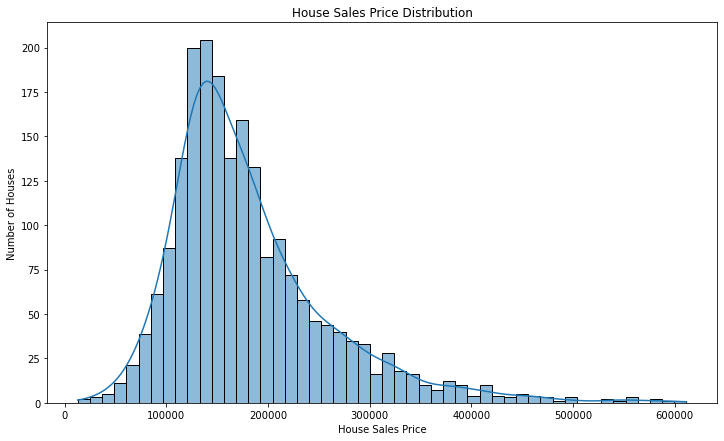

In [42]:
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(df['SalePrice'], bins = 50,kde=True)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution");

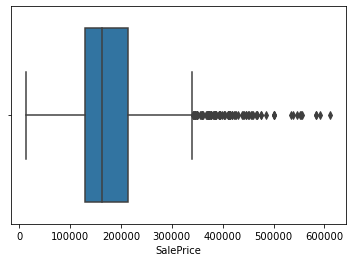

In [43]:
sns.boxplot(df["SalePrice"]);

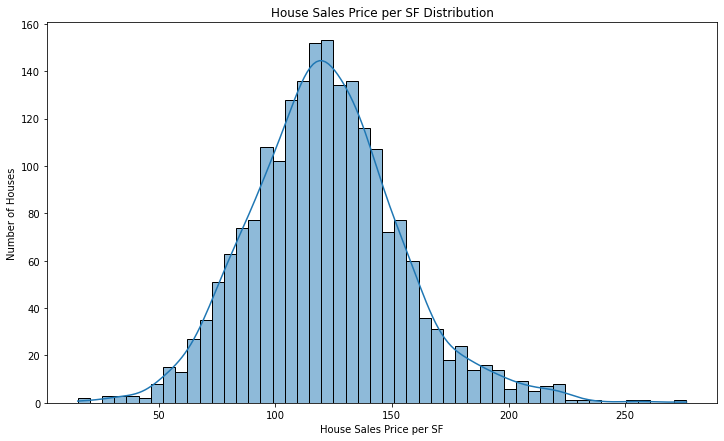

In [44]:
#price per sf
df['SalePricePerSF'] = df.loc[:,'SalePrice']/df.loc[:,'Gr Liv Area']
target=df['SalePricePerSF']
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(target, bins = 50,kde=True)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price per SF")
plt.ylabel("Number of Houses")
plt.title("House Sales Price per SF Distribution");

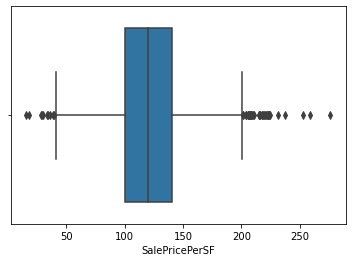

In [45]:
sns.boxplot(df["SalePricePerSF"]);

In [46]:
df[df["SalePricePerSF"]<50].sort_values(by='SalePricePerSF')

,Id,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SalePricePerSF
1628,182,902207130,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0.000,TA,Fa,BrkTil,Fa,Fa,No,Unf,0.000,Unf,0.000,678.000,678.000,GasA,TA,N,SBrkr,832,0,0,832,0.000,0.000,1,0,2,1,TA,5,Typ,1,Detchd,"1,928.000",Unf,2.000,780.000,Fa,Fa,N,0,0,0,0,0,0,0,6,2010,WD,12789,15.371
183,1554,910251050,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.000,Fa,Po,Slab,NA,NA,NA,NA,0.000,NA,0.000,0.000,0.000,Wall,Po,N,FuseA,733,0,0,733,0.000,0.000,1,0,2,1,Fa,4,Sal,0,Attchd,"1,952.000",Unf,2.000,487.000,Fa,Po,N,0,0,0,0,0,0,0,2,2008,WD,13100,17.872
960,1499,908154235,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,"5,644.000",Unf,0.000,466.000,"6,110.000",GasA,Ex,Y,SBrkr,4692,950,0,5642,2.000,0.000,2,1,3,1,Ex,12,Typ,3,Attchd,"2,008.000",Fin,2.000,"1,418.000",TA,TA,Y,214,292,0,0,0,480,0,1,2008,New,160000,28.359
162,754,903430070,90,RM,3000,Pave,Reg,Bnk,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,2Story,5,1,1922,1950,Hip,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil,TA,Fa,No,Unf,0.000,Unf,0.000,"1,040.000","1,040.000",GasA,TA,N,SBrkr,1088,1040,0,2128,0.000,0.000,2,0,4,2,TA,11,Sev,0,NA,0.000,NA,0.000,0.000,NA,NA,Y,0,56,0,0,0,0,0,9,2009,WD,62500,29.370
408,1556,911102170,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.000,TA,Fa,BrkTil,TA,TA,No,Unf,0.000,Unf,0.000,649.000,649.000,GasA,TA,N,SBrkr,649,668,0,1317,0.000,0.000,1,0,3,1,TA,6,Typ,0,Detchd,"1,920.000",Unf,1.000,250.000,TA,Fa,N,0,54,172,0,0,0,0,7,2008,WD,40000,30.372
1301,2044,903484080,50,RM,10320,Pave,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,Fa,Fa,CBlock,TA,Fa,No,Unf,0.000,Unf,0.000,771.000,771.000,GasA,Fa,Y,SBrkr,866,504,114,1484,0.000,0.000,2,0,3,1,TA,6,Sal,0,Detchd,"1,910.000",Unf,1.000,264.000,TA,Fa,N,14,211,0,0,84,0,0,9,2007,COD,50000,33.693
562,187,902401060,190,RM,9045,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,5,3,1910,1950,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,Fa,BrkTil,TA,TA,Mn,Unf,0.000,Unf,0.000,840.000,840.000,Grav,Fa,N,FuseF,1128,1128,0,2256,0.000,0.000,2,0,4,2,Fa,12,Typ,0,NA,0.000,NA,0.000,0.000,NA,NA,N,0,18,18,0,0,0,0,6,2010,WD,76500,33.910
1885,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,"1,224.000",Ex,TA,PConc,Ex,TA,Gd,GLQ,"4,010.000",Unf,0.000,"1,085.000","5,095.000",GasA,Ex,Y,SBrkr,5095,0,0,5095,1.000,1.000,2,1,2,1,Ex,15,Typ,2,Attchd,"2,008.000",Fin,3.000,"1,154.000",TA,TA,Y,546,484,0,0,0,0,17000,10,2007,New,183850,36.084
893,1994,902302150,190,RM,13600,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,5,5,1900,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0.000,Unf,0.000,662.000,662.000,GasA,TA,N,SBrkr,1422,915,0,2337,0.000,0.000,2,0,5,2,TA,

**outliers rows:**
- first two rows (index=1628,183) have sale price per sf less than 20, which is too far lower than the rest 
- rows (index=960,1885) are new house but with sale price per sf less than 30, too far lower than the rest



In [47]:
df[df["SalePricePerSF"]>230].sort_values(by='SalePrice',ascending=False)

,Id,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SalePricePerSF
1671,45,528150070,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,"2,188.000",Unf,0.000,142.000,"2,330.000",GasA,Ex,Y,SBrkr,2364,0,0,2364,1.000,0.000,2,1,2,1,Ex,11,Typ,2,Attchd,"2,009.000",Fin,3.000,820.000,TA,TA,Y,0,67,0,0,0,0,0,3,2010,New,611657,258.738
1964,1638,527216080,20,RL,51974,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,PosN,Norm,1Fam,1Story,9,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,710.000,Ex,TA,PConc,Ex,TA,Av,GLQ,"1,101.000",Unf,0.000,"1,559.000","2,660.000",GasA,Ex,Y,SBrkr,2338,0,0,2338,1.000,0.000,2,1,4,1,Gd,8,Typ,2,Attchd,"2,005.000",Fin,3.000,"1,110.000",Gd,TA,Y,0,135,0,0,322,0,0,6,2007,New,591587,253.031
1164,424,528106020,20,RL,15431,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,"1,767.000",ALQ,539.000,788.000,"3,094.000",GasA,Ex,Y,SBrkr,2402,0,0,2402,1.000,0.000,2,0,2,1,Ex,10,Typ,2,Attchd,"2,008.000",Fin,3.000,672.000,TA,TA,Y,0,72,0,0,170,0,0,4,2009,WD,555000,231.057
1758,1560,911370410,120,RM,5587,Pave,IR1,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,TwnhsE,1Story,8,5,2008,2008,Hip,CompShg,CemntBd,CmentBd,Stone,186.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,"1,480.000",Unf,0.000,120.000,"1,600.000",GasA,Ex,Y,SBrkr,1652,0,0,1652,1.000,1.000,2,0,2,1,Gd,5,Typ,1,Attchd,"2,008.000",Fin,2.000,482.000,TA,TA,Y,162,53,0,153,0,0,0,11,2008,New,392500,237.591
1136,1641,527252070,20,RL,8089,Pave,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.000,Gd,TA,PConc,Gd,TA,Av,GLQ,945.000,Unf,0.000,474.000,"1,419.000",GasA,Ex,Y,SBrkr,1419,0,0,1419,1.000,0.000,2,0,2,1,Gd,7,Typ,1,Attchd,"2,007.000",RFn,2.000,567.000,TA,TA,Y,140,0,0,0,0,0,0,10,2007,New,392000,276.251


**Observations:**
- All those house have huge Lot Area,finished basement area and living area. We cannot judge if they are abnormal 


In [48]:
#delete abnormal rows
outliers_index=[1628,183,960,1885]
#delete the outliers
print(df.shape)
df=df.drop(index=outliers_index)
print(df.shape)

(2051, 76)
(2047, 76)


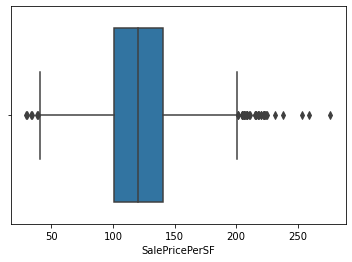

In [49]:
sns.boxplot(df["SalePricePerSF"]);

### EDA features_numeric

**sort features_numeric by absolute skewness ascendingly**

In [50]:
features_numeric=sorted_by_abs_skew(df, features_numeric)

            feature  skewness  abs_skewness
14        Full Bath     0.107         0.107
31          Yr Sold     0.154         0.154
22      Garage Area     0.156         0.156
30          Mo Sold     0.214         0.214
21      Garage Cars    -0.228         0.228
16    Bedroom AbvGr     0.368         0.368
7     Total Bsmt SF     0.430         0.430
4    Year Remod/Add    -0.452         0.452
3        Year Built    -0.609         0.609
12   Bsmt Full Bath     0.627         0.627
19       Fireplaces     0.713         0.713
15        Half Bath     0.744         0.744
18    TotRms AbvGrd     0.778         0.778
2      BsmtFin SF 1     0.809         0.809
9        2nd Flr SF     0.874         0.874
6       Bsmt Unf SF     0.910         0.910
11      Gr Liv Area     0.926         0.926
8        1st Flr SF     0.962         0.962
23     Wood Deck SF     2.019         2.019
24    Open Porch SF     2.241         2.241
1      Mas Vnr Area     2.569         2.569
25   Enclosed Porch     2.861   

**plot**
- histographs of numeric features
- pairplot of numeric features and "SalePrice"

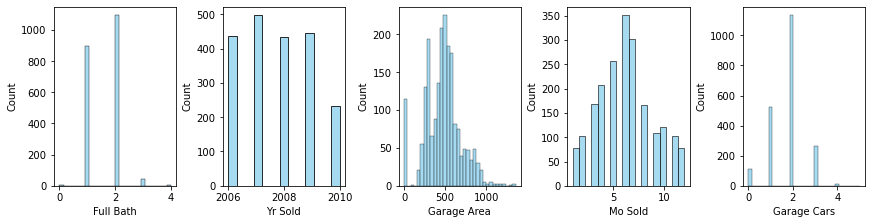

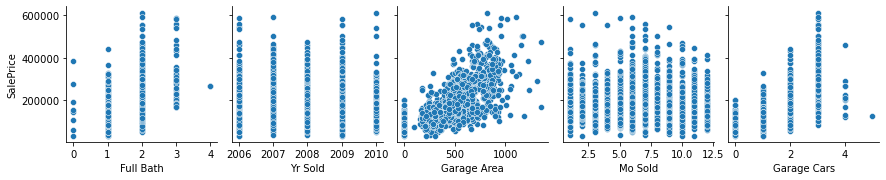

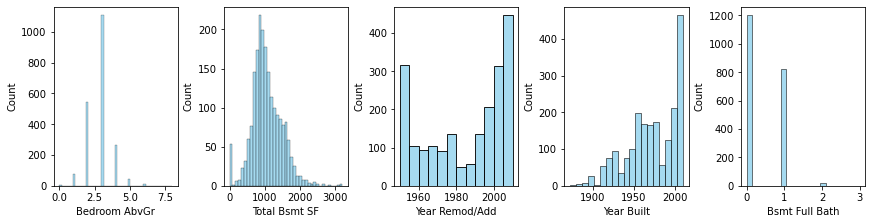

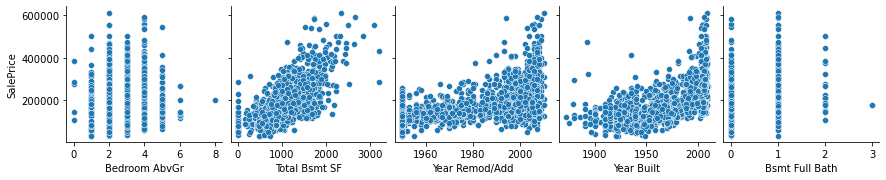

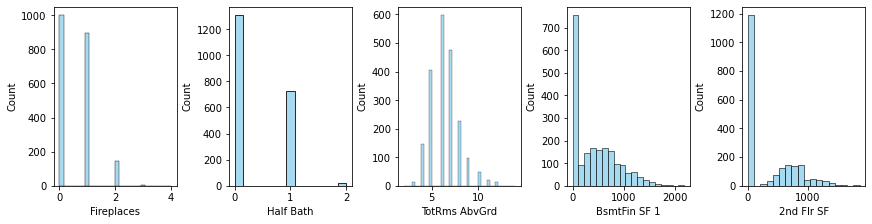

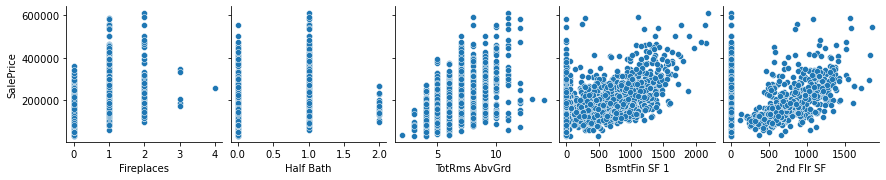

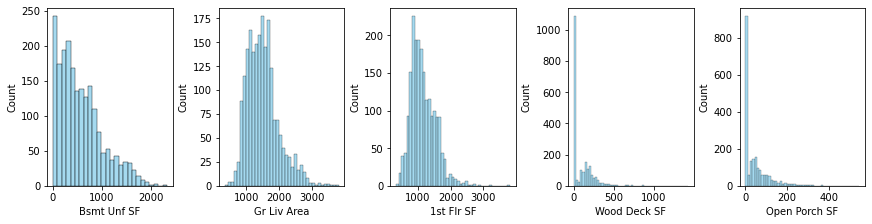

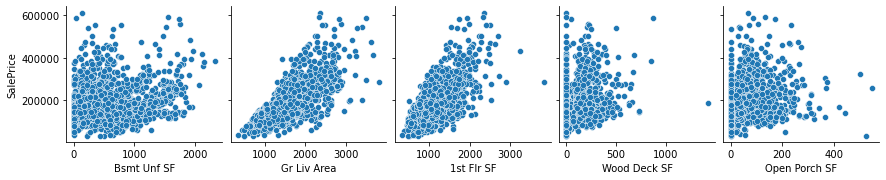

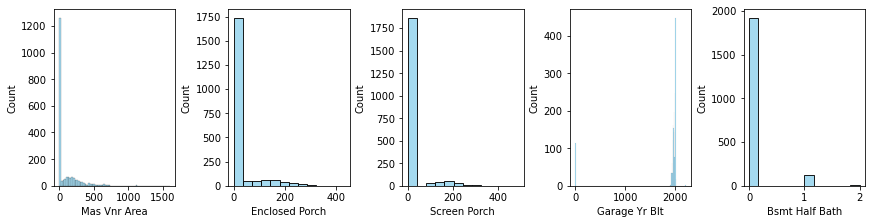

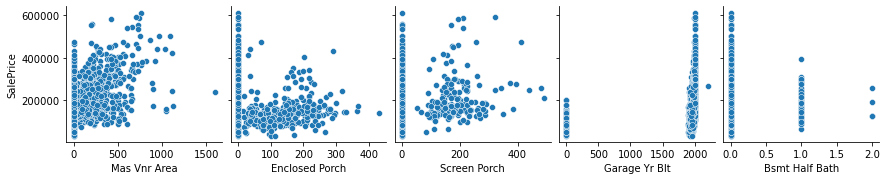

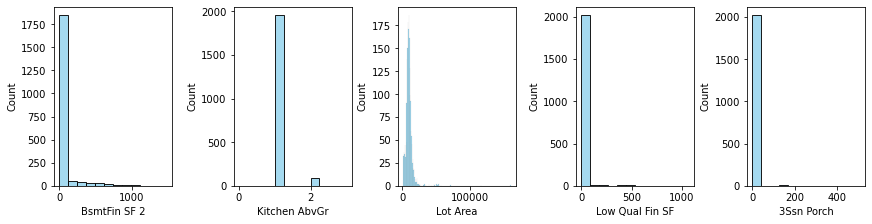

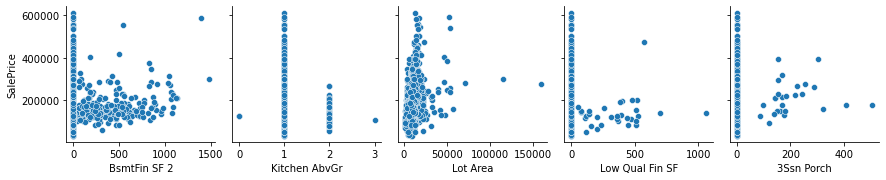

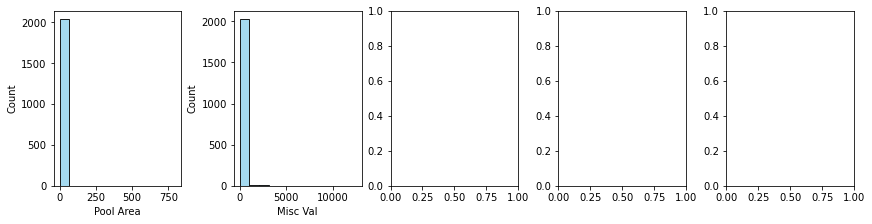

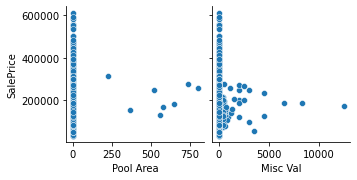

In [51]:
#plot_features(df,x_columns, y_column, columns_in_a_row = 5, feature_type='numeric')
plot_features(df, features_numeric, target_variable,columns_in_a_row = 5, feature_type='numeric')

**observations**
- some features are highly skew
- outliers are detected for most features
- for last 5 features, their skewness are more than 9, too skew to decide if there are outliers, we will not handle outliers for those features

**checking outliers of features_numeric**

In [52]:
outliers_index = get_indexs_of_outliers_IQR(df, features_numeric, 2.5, direction="upper")
print(f"there are {len(outliers_index)} outliers found in features_numeric")

feature name: Full Bath
Percentiles: 25th=1.000, 75th=2.000, IQR=1.000
index of outliers: set()
feature name: Yr Sold
Percentiles: 25th=2007.000, 75th=2009.000, IQR=2.000
index of outliers: set()
feature name: Garage Area
Percentiles: 25th=319.000, 75th=576.000, IQR=257.000
index of outliers: {1158, 682, 1293, 337, 1557}
feature name: Mo Sold
Percentiles: 25th=4.000, 75th=8.000, IQR=4.000
index of outliers: set()
feature name: Garage Cars
Percentiles: 25th=1.000, 75th=2.000, IQR=1.000
index of outliers: {925}
feature name: Bedroom AbvGr
Percentiles: 25th=2.000, 75th=3.000, IQR=1.000
index of outliers: {1889, 194, 1605, 1256, 1451, 530, 822, 534, 984, 1366, 858, 1789, 1566}
feature name: Total Bsmt SF
Percentiles: 25th=793.000, 75th=1317.500, IQR=524.500
index of outliers: {328, 1227, 1164, 1964, 1147, 1117}
feature name: Year Remod/Add
Percentiles: 25th=1964.500, 75th=2004.000, IQR=39.500
index of outliers: set()
feature name: Year Built
Percentiles: 25th=1954.000, 75th=2001.000, IQR=4

**delete outliers of features_numeric**

In [53]:
#delete the outliers
print(df.shape)
df=df.drop(index=outliers_index)
print(df.shape)

(2047, 76)
(1875, 76)


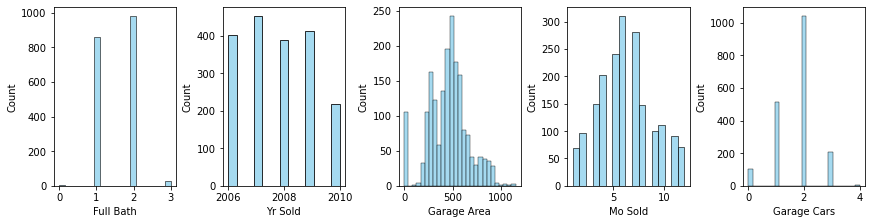

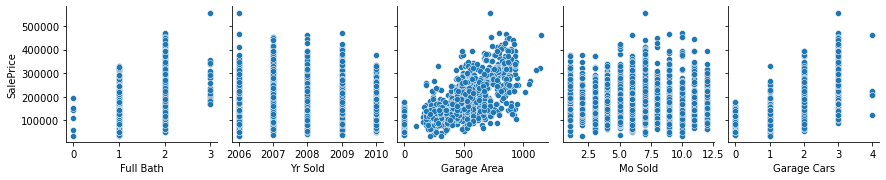

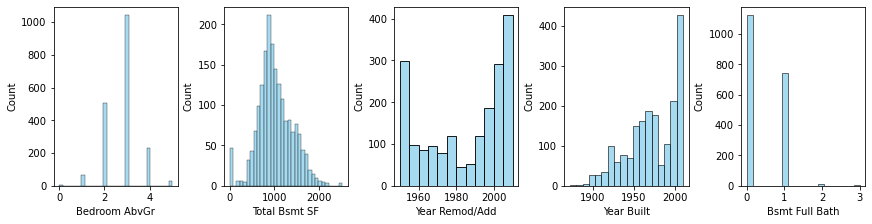

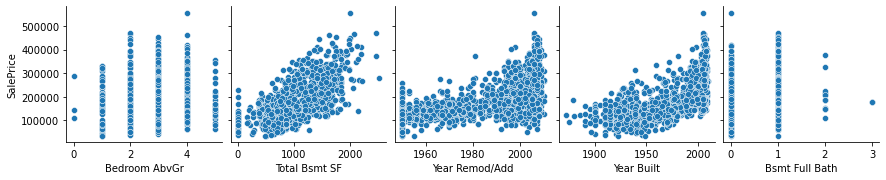

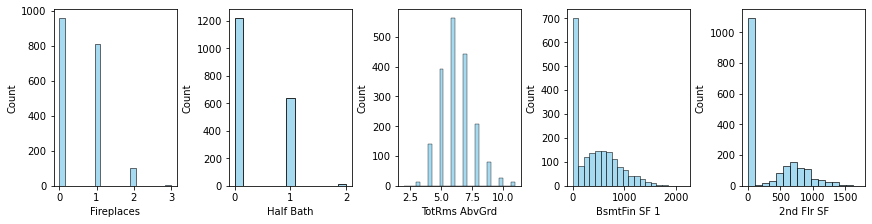

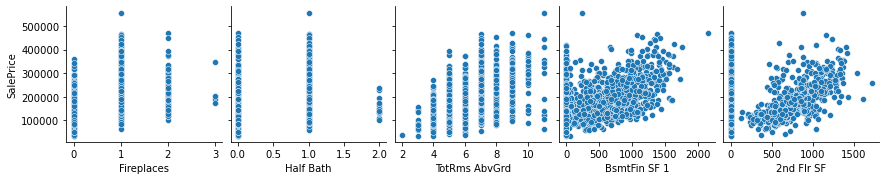

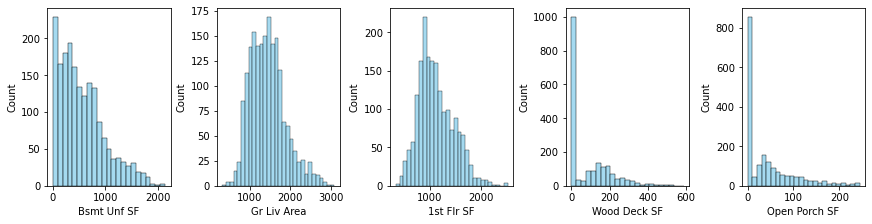

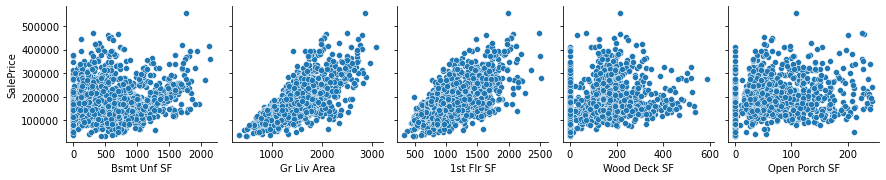

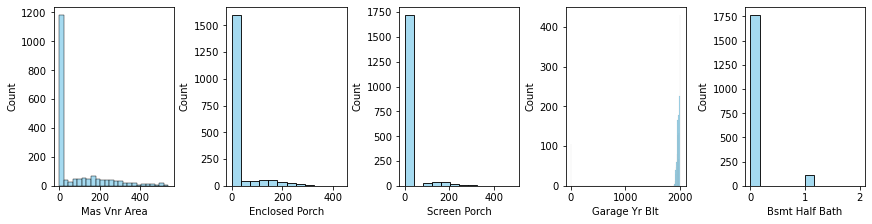

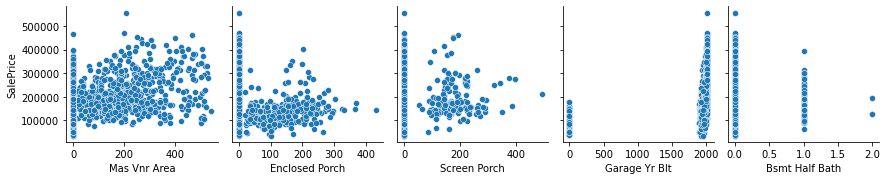

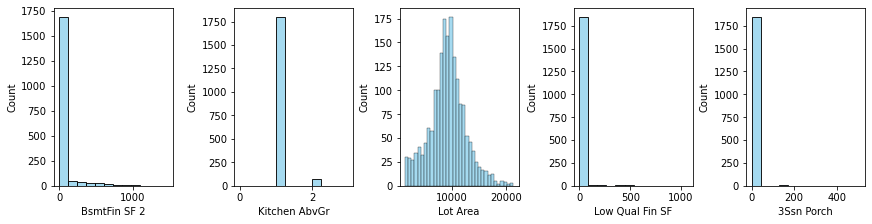

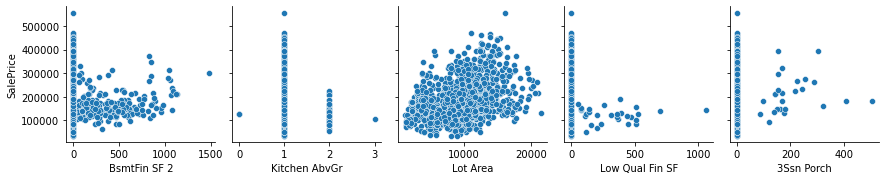

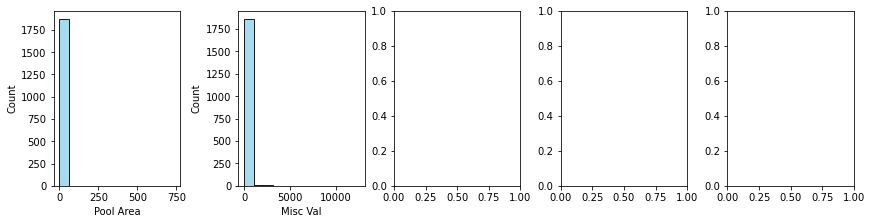

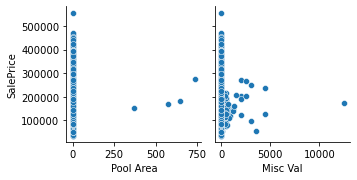

In [54]:
#plot_features(df,x_columns, y_column, columns_in_a_row = 5, feature_type='numeric')
plot_features(df, features_numeric, target_variable,columns_in_a_row = 5, feature_type='numeric')

**We notes:**
- many features highly imbalance
- there still are some outliers which are very easy to spot, but most such outliers belong to highly-imbalanced features.



## EDA and target-encoding Features_ordinal

**plot**
- histographs of numeric features
- pairplot of numeric features and "SalePrice"

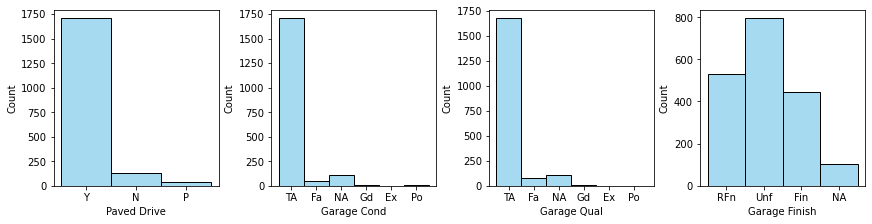

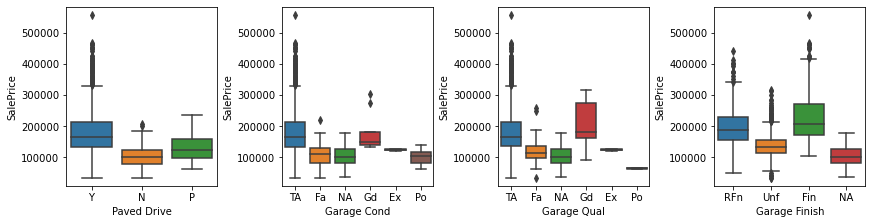

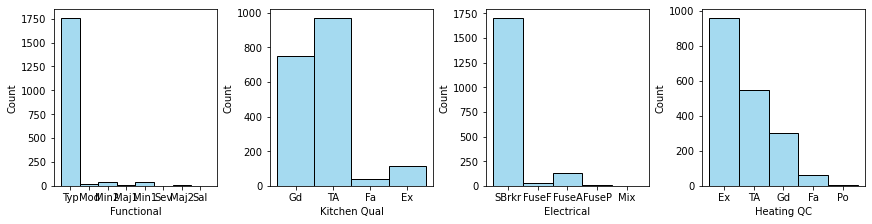

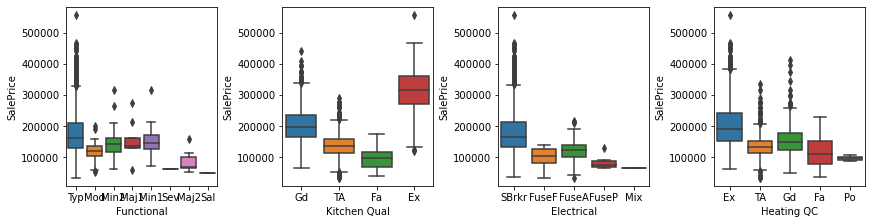

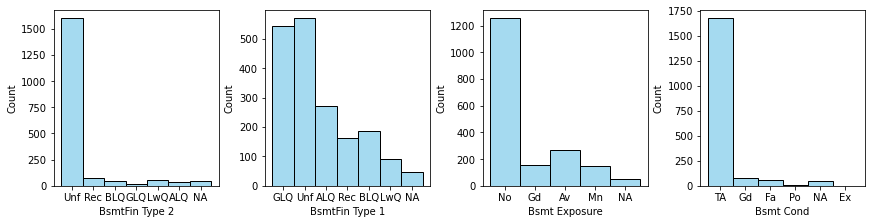

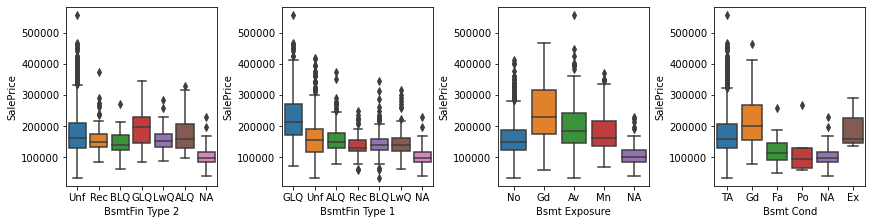

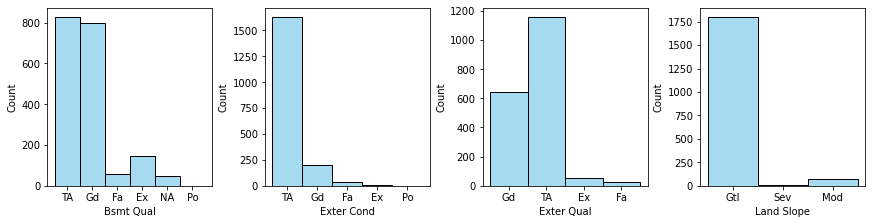

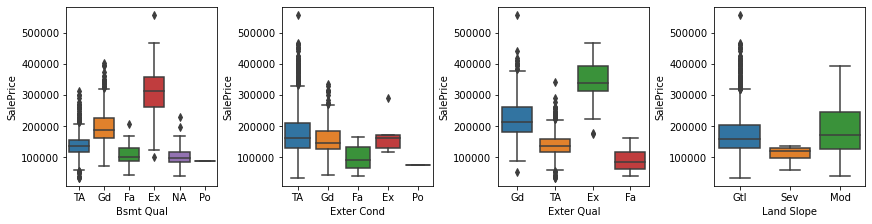

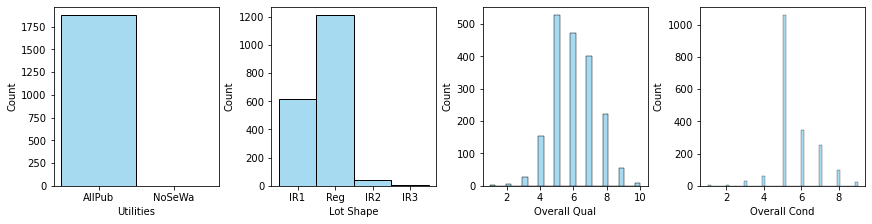

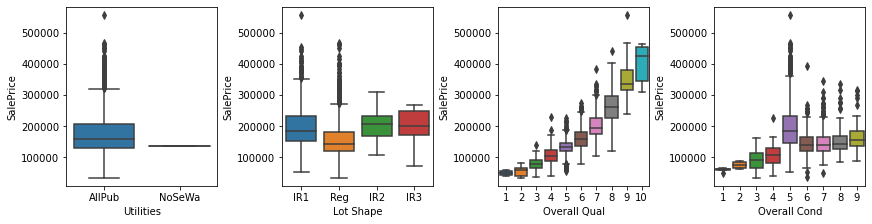

In [55]:
plot_features(df, features_ordinal, target_variable,columns_in_a_row = 4, feature_type='ordinal')

**we note**

- most features are imbalanced
- most features seem not corration with 'SalePrice'

In [56]:
 
ordinal_cols_mapping_target_encoding=get_mapping_target_median_encoding(df, features_ordinal,target_variable)


{'Paved Drive': {'N': 101000.0, 'P': 124450.0, 'Y': 165000.0}, 'Garage Cond': {'Ex': 124000.0, 'Fa': 110000.0, 'Gd': 148000.0, 'NA': 102000.0, 'Po': 106000.0, 'TA': 165150.0}, 'Garage Qual': {'Ex': 124000.0, 'Fa': 113000.0, 'Gd': 180000.0, 'NA': 102000.0, 'Po': 65000.0, 'TA': 165750.0}, 'Garage Finish': {'Fin': 206300.0, 'NA': 102000.0, 'RFn': 188250.0, 'Unf': 134500.0}, 'Functional': {'Maj1': 135750.0, 'Maj2': 68104.0, 'Min1': 145250.0, 'Min2': 142900.0, 'Mod': 122000.0, 'Sal': 50000.0, 'Sev': 62500.0, 'Typ': 160750.0}, 'Kitchen Qual': {'Ex': 317250.0, 'Fa': 97275.0, 'Gd': 196000.0, 'TA': 135000.0}, 'Electrical': {'FuseA': 122250.0, 'FuseF': 105000.0, 'FuseP': 75000.0, 'Mix': 67000.0, 'SBrkr': 165000.0}, 'Heating QC': {'Ex': 191000.0, 'Fa': 111000.0, 'Gd': 149625.0, 'Po': 97000.0, 'TA': 133600.0}, 'BsmtFin Type 2': {'ALQ': 160000.0, 'BLQ': 138750.0, 'GLQ': 198625.0, 'LwQ': 154000.0, 'NA': 98000.0, 'Rec': 150000.0, 'Unf': 162500.0}, 'BsmtFin Type 1': {'ALQ': 150000.0, 'BLQ': 138500.0, 

In [57]:
df = df.replace(ordinal_cols_mapping_target_encoding)

In [58]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['ordinal_cols_mapping_target_encoding']=ordinal_cols_mapping_target_encoding


In [59]:
df[features_ordinal].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 2050
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Paved Drive     1875 non-null   float64
 1   Garage Cond     1875 non-null   float64
 2   Garage Qual     1875 non-null   float64
 3   Garage Finish   1875 non-null   float64
 4   Functional      1875 non-null   float64
 5   Kitchen Qual    1875 non-null   float64
 6   Electrical      1875 non-null   float64
 7   Heating QC      1875 non-null   float64
 8   BsmtFin Type 2  1875 non-null   float64
 9   BsmtFin Type 1  1875 non-null   float64
 10  Bsmt Exposure   1875 non-null   float64
 11  Bsmt Cond       1875 non-null   float64
 12  Bsmt Qual       1875 non-null   float64
 13  Exter Cond      1875 non-null   float64
 14  Exter Qual      1875 non-null   float64
 15  Land Slope      1875 non-null   float64
 16  Utilities       1875 non-null   float64
 17  Lot Shape       1875 non-null   f

**sort features_ordinal by absolute skewness ascendingly**

In [60]:
features_ordinal=sorted_by_abs_skew(df, features_ordinal)

           feature  skewness  abs_skewness
3    Garage Finish    -0.136         0.136
7       Heating QC    -0.266         0.266
15      Land Slope    -0.341         0.341
9   BsmtFin Type 1     0.510         0.510
17       Lot Shape     0.704         0.704
19    Overall Cond    -0.865         0.865
10   Bsmt Exposure     1.302         1.302
18    Overall Qual     1.305         1.305
11       Bsmt Cond    -1.398         1.398
14      Exter Qual     1.422         1.422
12       Bsmt Qual     1.513         1.513
5     Kitchen Qual     1.530         1.530
2      Garage Qual    -2.747         2.747
1      Garage Cond    -2.987         2.987
0      Paved Drive    -3.006         3.006
6       Electrical    -3.273         3.273
8   BsmtFin Type 2    -3.635         3.635
13      Exter Cond    -5.027         5.027
4       Functional    -7.779         7.779
16       Utilities   -43.301        43.301

features sorted: 
 ['Garage Finish', 'Heating QC', 'Land Slope', 'BsmtFin Type 1', 'Lot Shape', 

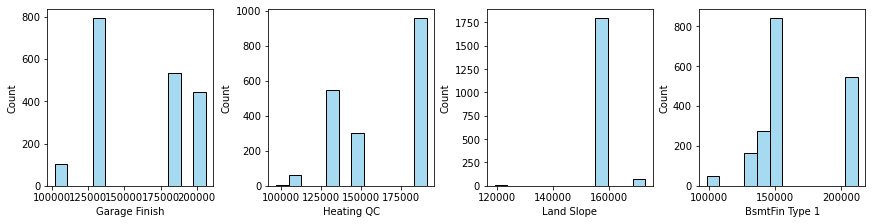

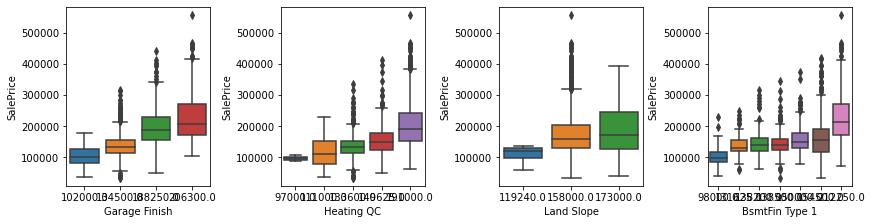

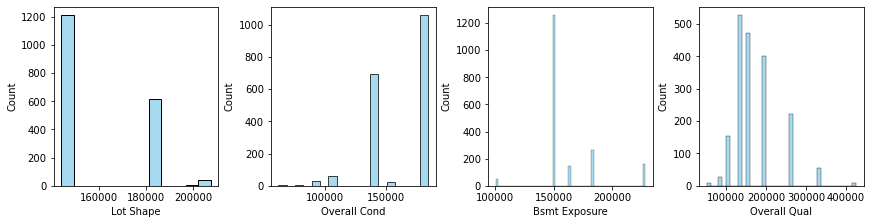

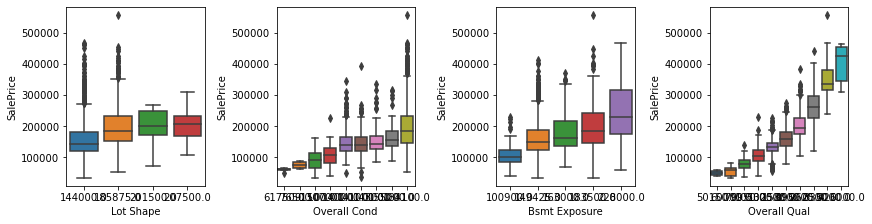

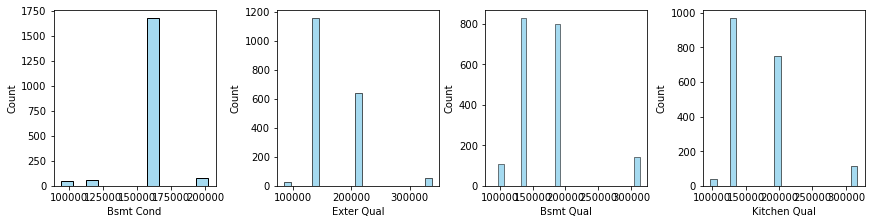

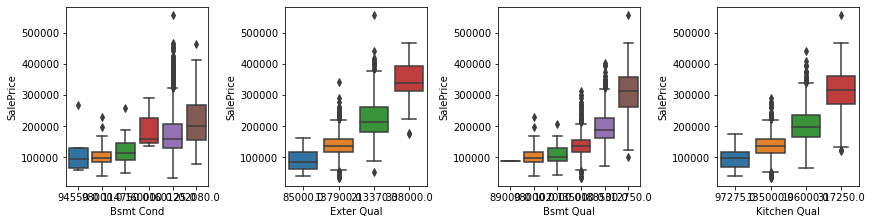

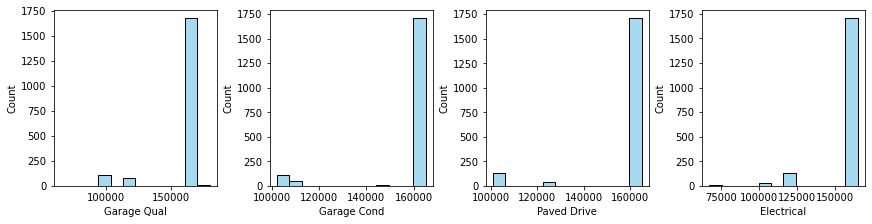

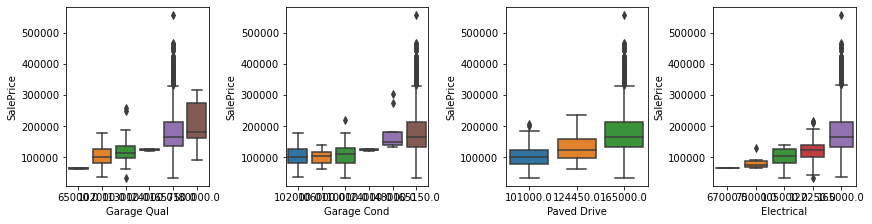

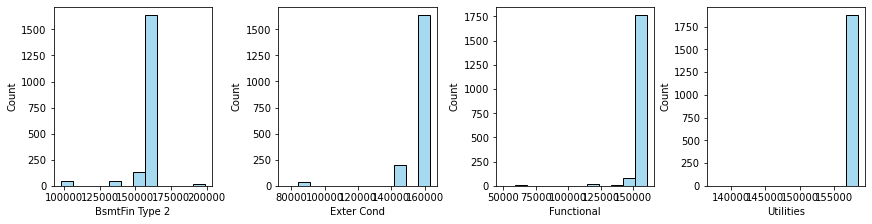

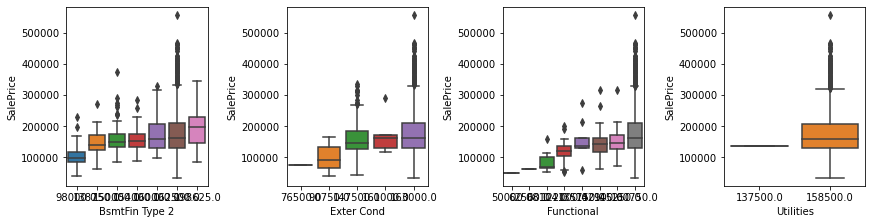

In [61]:
plot_features(df, features_ordinal, target_variable,columns_in_a_row = 4, feature_type='ordinal')

**observations**
- 1
- 2
- 3

## EDA and target-encoding Features_categorical

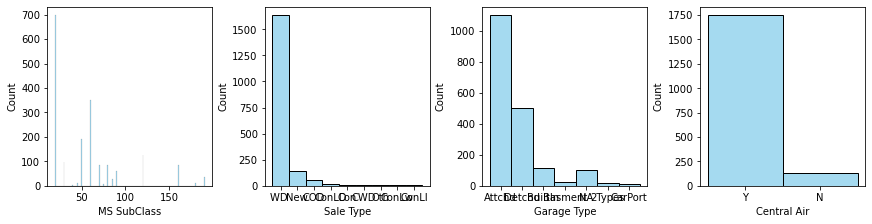

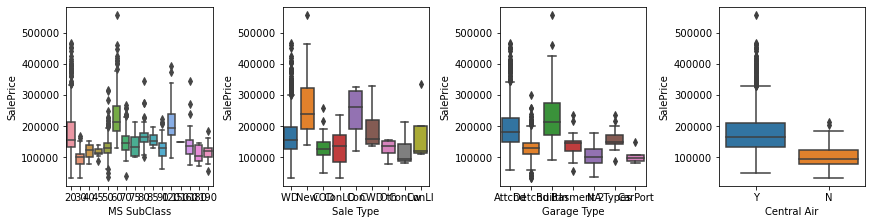

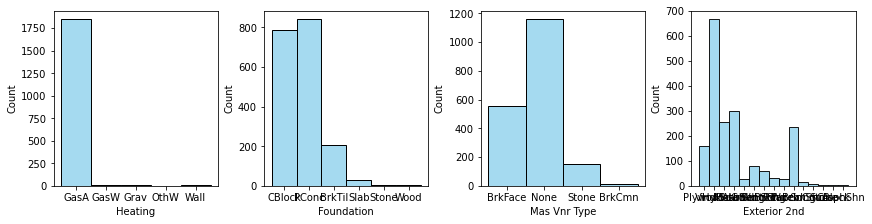

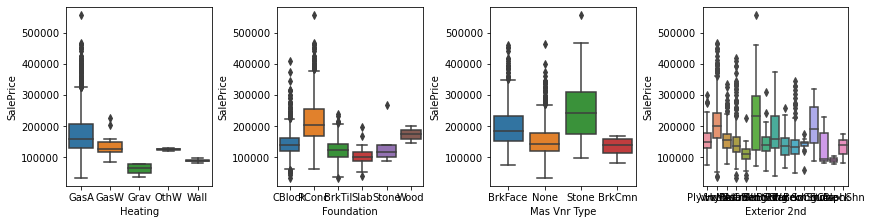

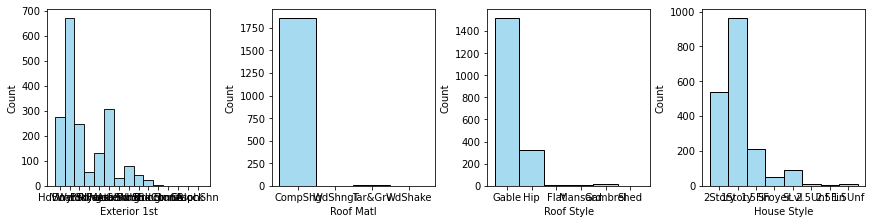

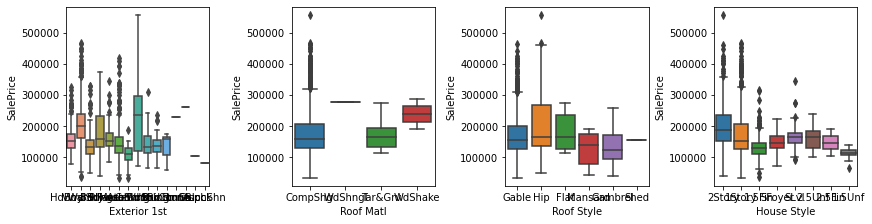

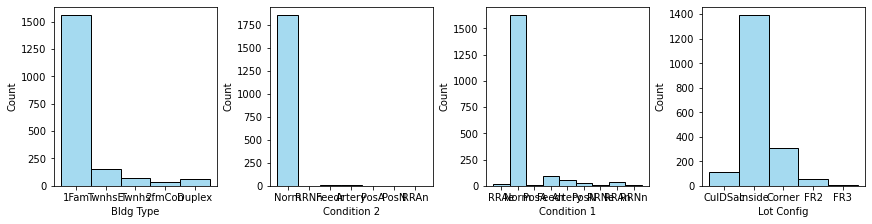

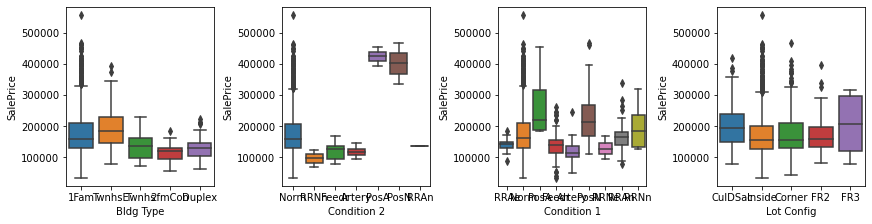

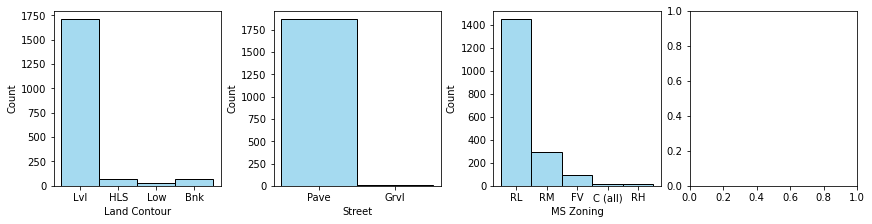

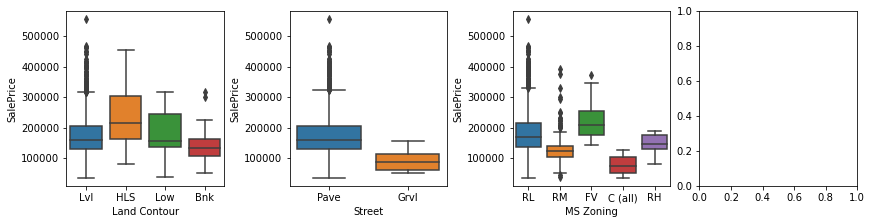

In [62]:
plot_features(df, features_categorical, target_variable,columns_in_a_row = 4, feature_type='categorical')

**We note that**
- imbalance
- from boxplot, most mean value don't have big difference, and combined with the histogram, the features with high count tends to have big range 


In [63]:
categorical_cols_mapping_target_encoding=get_mapping_target_median_encoding(df, features_categorical,target_variable)

{'MS SubClass': {20: 157000.0, 30: 99650.0, 40: 122500.0, 45: 113000.0, 50: 128900.0, 60: 212554.5, 70: 146500.0, 75: 132000.0, 80: 165000.0, 85: 150950.0, 90: 128600.0, 120: 194700.0, 150: 148400.0, 160: 138000.0, 180: 105000.0, 190: 119750.0}, 'Sale Type': {'COD': 126000.0, 'CWD': 158000.0, 'Con': 261615.0, 'ConLD': 135000.0, 'ConLI': 119000.0, 'ConLw': 95000.0, 'New': 237837.5, 'Oth': 137050.0, 'WD ': 155000.0}, 'Garage Type': {'2Types': 148250.0, 'Attchd': 182900.0, 'Basment': 145000.0, 'BuiltIn': 214450.0, 'CarPort': 98400.0, 'Detchd': 128550.0, 'NA': 101000.0}, 'Central Air': {'N': 96000.0, 'Y': 164600.0}, 'Heating': {'GasA': 159697.5, 'GasW': 127500.0, 'Grav': 65750.0, 'OthW': 125750.0, 'Wall': 90000.0}, 'Foundation': {'BrkTil': 124900.0, 'CBlock': 139500.0, 'PConc': 203000.0, 'Slab': 99900.0, 'Stone': 118000.0, 'Wood': 173750.0}, 'Mas Vnr Type': {'BrkCmn': 139000.0, 'BrkFace': 184000.0, 'None': 142500.0, 'Stone': 241000.0}, 'Exterior 2nd': {'AsbShng': 111500.0, 'AsphShn': 13900

In [64]:

df = df.replace(categorical_cols_mapping_target_encoding)
print(df.shape)
df.head(2)

(1875, 76)


,Id,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SalePricePerSF
0,109,533352170,"212,554.500","168,000.000",13517,"159,000.000","185,875.000","158,000.000","158,500.000","193,000.000","158,000.000",Sawyer,"143,200.000","159,000.000","160,000.000","186,450.000","158,000.000","143,000.000",1976,2005,"157,000.000","158,225.000","153,500.000","150,000.000","184,000.000",289.000,"213,370.000","163,000.000","139,500.000","135,000.000","160,125.000","149,425.000","212,250.000",533.000,"162,500.000",0.000,192.000,725.000,"159,697.500","191,000.000","164,600.000","165,000.000",725,754,0,1479,0.000,0.000,2,1,3,1,"196,000.000",6,"160,750.000",0,"182,900.000","1,976.000","188,250.000",2.000,475.000,"165,750.000","165,150.000","165,000.000",0,44,0,0,0,0,0,3,2010,"155,000.000",130500,88.235
1,544,531379050,"212,554.500","168,000.000",11492,"159,000.000","185,875.000","158,000.000","158,500.000","193,000.000","158,000.000",SawyerW,"163,250.000","159,000.000","160,000.000","186,450.000","195,000.000","184,100.000",1996,1997,"157,000.000","158,225.000","199,250.000","199,500.000","184,000.000",132.000,"213,370.000","163,000.000","203,000.000","188,500.000","160,125.000","149,425.000","212,250.000",637.000,"162,500.000",0.000,276.000,913.000,"159,697.500","191,000.000","164,600.000","165,000.000",913,1209,0,2122,1.000,0.000,2,1,4,1,"196,000.000",8,"160,750.000",1,"182,900.000","1,997.000","188,250.000",2.000,559.000,"165,750.000","165,150.000","165,000.000",0,74,0,0,0,0,0,4,2009,"155,000.000",220000,103.676


In [65]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['categorical_cols_mapping_target_encoding']=categorical_cols_mapping_target_encoding


**sort features_categorical by absolute skewness ascendingly**

In [66]:
features_categorical=sorted_by_abs_skew(df, features_categorical)

         feature  skewness  abs_skewness
5     Foundation     0.080         0.080
11   House Style     0.112         0.112
0    MS SubClass     0.272         0.272
7   Exterior 2nd     0.348         0.348
8   Exterior 1st     0.387         0.387
14   Condition 1    -0.475         0.475
2    Garage Type    -0.575         0.575
12     Bldg Type    -0.893         0.893
18     MS Zoning    -1.048         1.048
6   Mas Vnr Type     1.390         1.390
10    Roof Style    -1.819         1.819
1      Sale Type     2.677         2.677
16  Land Contour     3.364         3.364
3    Central Air    -3.410         3.410
15    Lot Config     3.652         3.652
4        Heating   -11.270        11.270
17        Street   -17.607        17.607
13   Condition 2    18.382        18.382
9      Roof Matl    25.925        25.925

features sorted: 
 ['Foundation', 'House Style', 'MS SubClass', 'Exterior 2nd', 'Exterior 1st', 'Condition 1', 'Garage Type', 'Bldg Type', 'MS Zoning', 'Mas Vnr Type', 'Roof Style

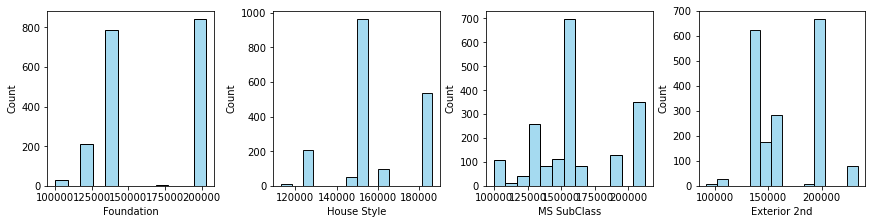

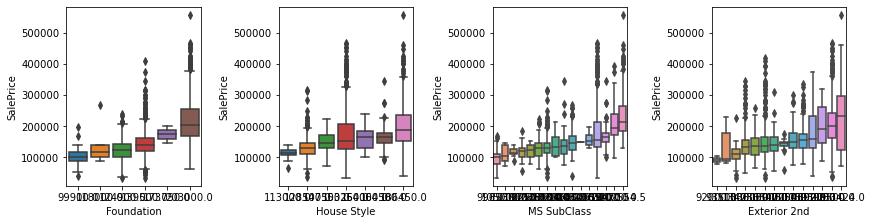

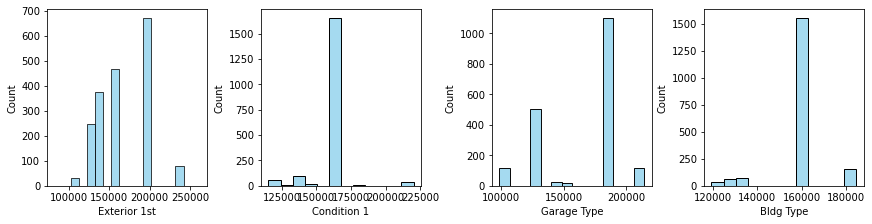

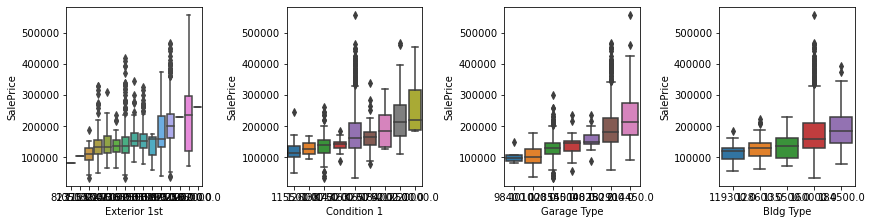

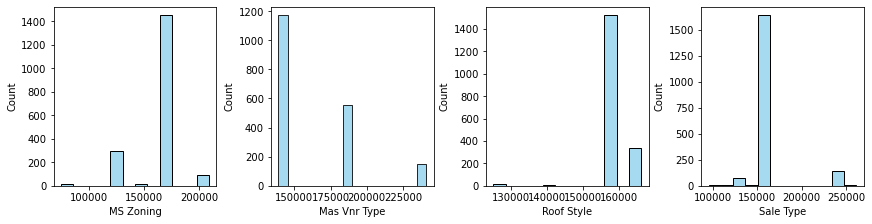

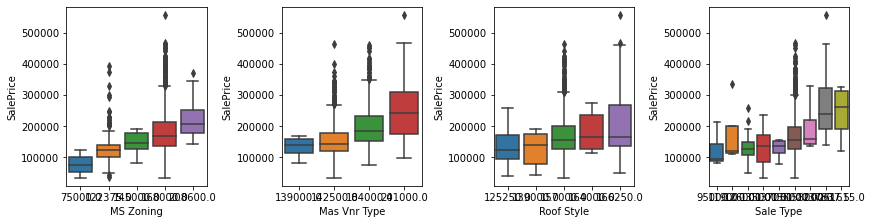

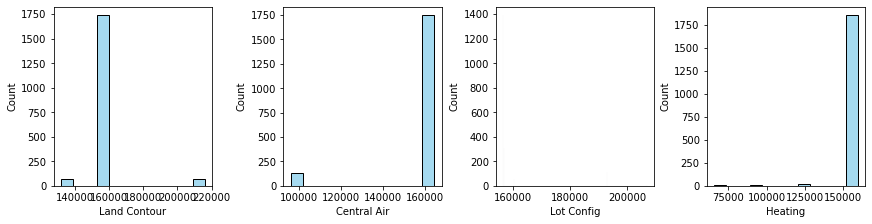

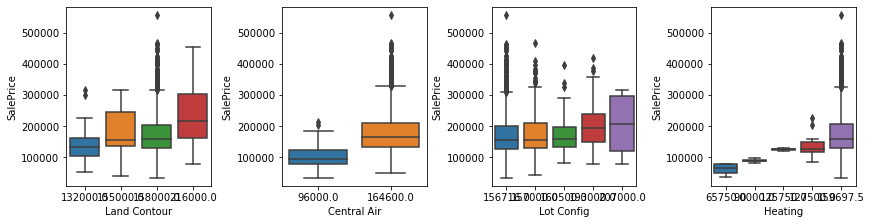

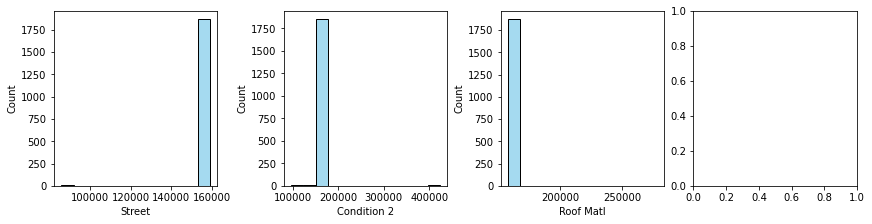

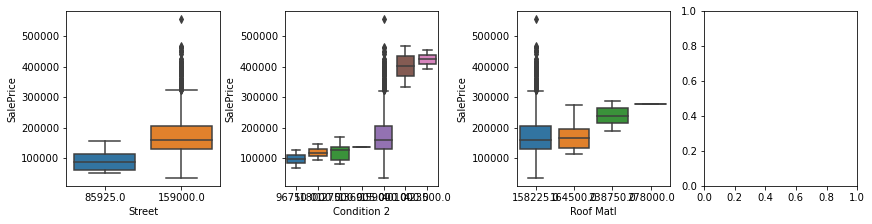

In [67]:
plot_features(df, features_categorical, target_variable,columns_in_a_row = 4, feature_type='categorical')

####  feature "Garage Yr Blt" ==> "Garage Age"
####  feature "Year Built" ==> "House Age"

df['Garage Age'] = df['Yr Sold'] - df["Garage Yr Blt"]
df['House Age'] = df['Yr Sold'] - df["Year Built"]
df['Remod/Add Age'] = df['Yr Sold'] - df['Year Remod/Add']
features_numeric.remove("Garage Yr Blt")
features_numeric.remove("Year Built")
features_numeric.remove('Year Remod/Add')
features_numeric.append('Garage Age')
features_numeric.append('House Age')
features_numeric.append('Remod/Add Age')
#df.drop(columns=["Garage Yr Blt","Year Built"],inplace=True)
print(features_numeric)

# Exporting Data

#Divide into test and train:
df_train = df.loc[df['source']=="train"]
df_test = df.loc[df['source']=="test"]#Drop unnecessary columns:
df_test.drop(['SalePrice','source'],axis=1,inplace=True)
df_train.drop(['source'],axis=1,inplace=True)#Export files as modified versions:
df_train.to_csv("../datasets/train_modified.csv",index=False)
df_test.to_csv("../datasets/test_modified.csv",index=False)

df=pd.read_csv("../datasets/train_modified.csv")
df.shape

# Feature Selection
**Basic Steps**
- select features with an high absolute correlation (>0.4) with "SalePrice"
- and then among those features, drop the features when they have high correlation (>0.6) with the others   

### selecting numeric features

In [68]:
features_numeric_selected = select_features_by_corr(df, features_numeric, target_variable, corr_threhold)

            feature   corr  abs_corr
1       Gr Liv Area  0.712     0.712
2       Garage Cars  0.663     0.663
3       Garage Area  0.654     0.654
4     Total Bsmt SF  0.640     0.640
5        1st Flr SF  0.618     0.618
6        Year Built  0.617     0.617
7    Year Remod/Add  0.577     0.577
8         Full Bath  0.550     0.550
9     TotRms AbvGrd  0.498     0.498
10     Mas Vnr Area  0.449     0.449
11       Fireplaces  0.449     0.449
12    Open Porch SF  0.404     0.404
13     BsmtFin SF 1  0.403     0.403
14         Lot Area  0.382     0.382
15     Wood Deck SF  0.318     0.318
16    Garage Yr Blt  0.277     0.277
17        Half Bath  0.273     0.273
18   Bsmt Full Bath  0.259     0.259
19       2nd Flr SF  0.243     0.243
20      Bsmt Unf SF  0.192     0.192
21    Bedroom AbvGr  0.156     0.156
22     Screen Porch  0.082     0.082
23       3Ssn Porch  0.068     0.068
24          Mo Sold  0.048     0.048
25        Pool Area  0.019     0.019
26     BsmtFin SF 2 -0.004     0.004
2

**checking multicollinearity of features_numeric_selected**

<AxesSubplot:>

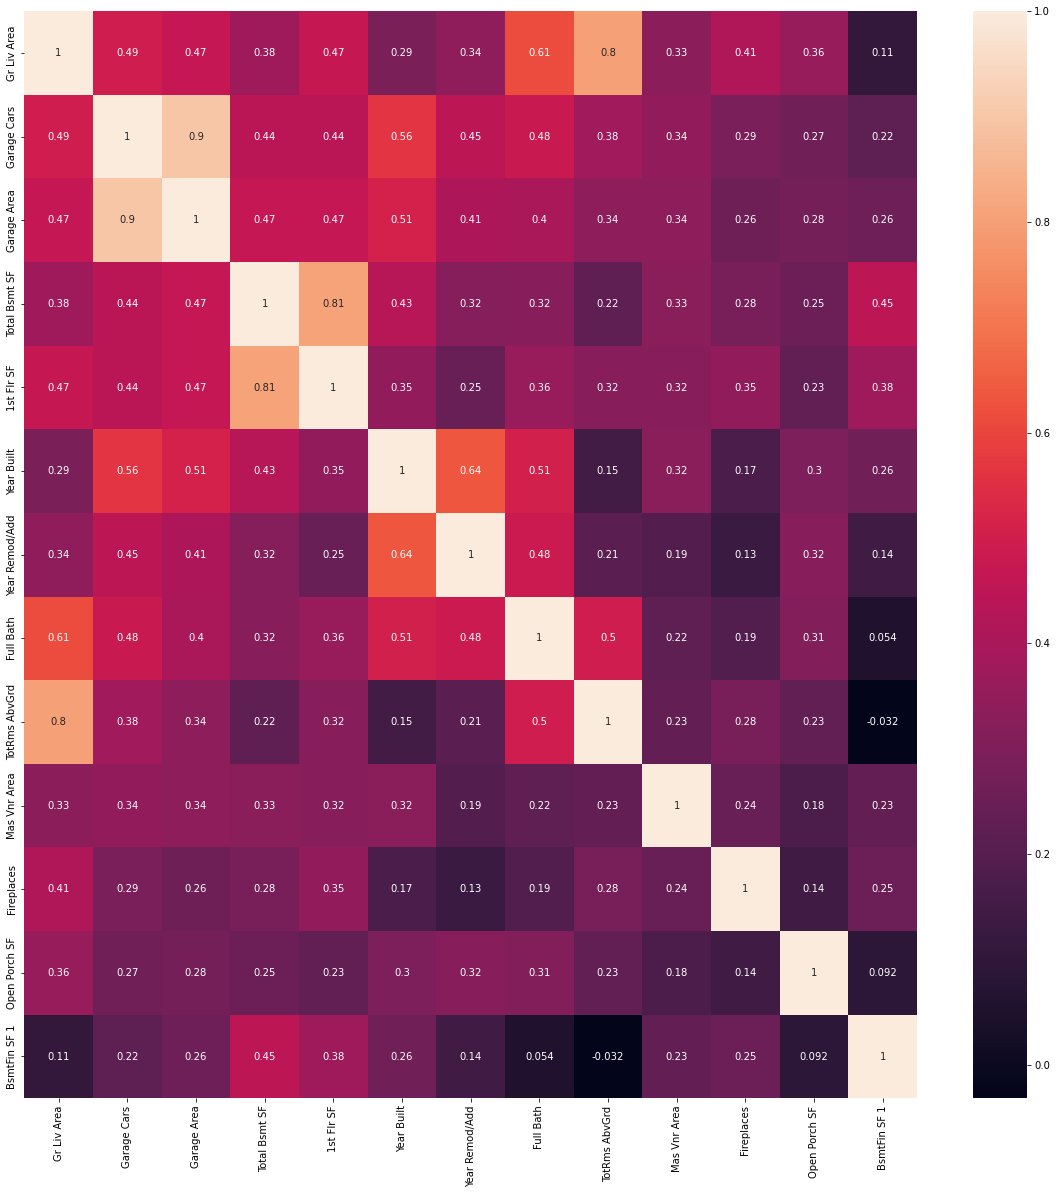

In [69]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_numeric_selected].corr(), annot=True)

**drop features with corr more than 0.6 with other features**
- we will keep those features with high corr with "SalePrice" when there is a multicollinearity conflict
- 'Gr Liv Area' is highly correlated with 'TotRms AbvGrd','Garage Area', we will drop the later two
- 'Total Bsmt SF' is highly correlated with '1st Flr SF'
- 'Year Built' is highly correlated with 'Year Remod/Add'

In [70]:
#drop the features casusing multicollinearity
features_numeric_selected = list(set(features_numeric_selected ) 
                                -
                                set(['TotRms AbvGrd','Full Bath','1st Flr SF','Garage Area','Year Remod/Add']))

<AxesSubplot:>

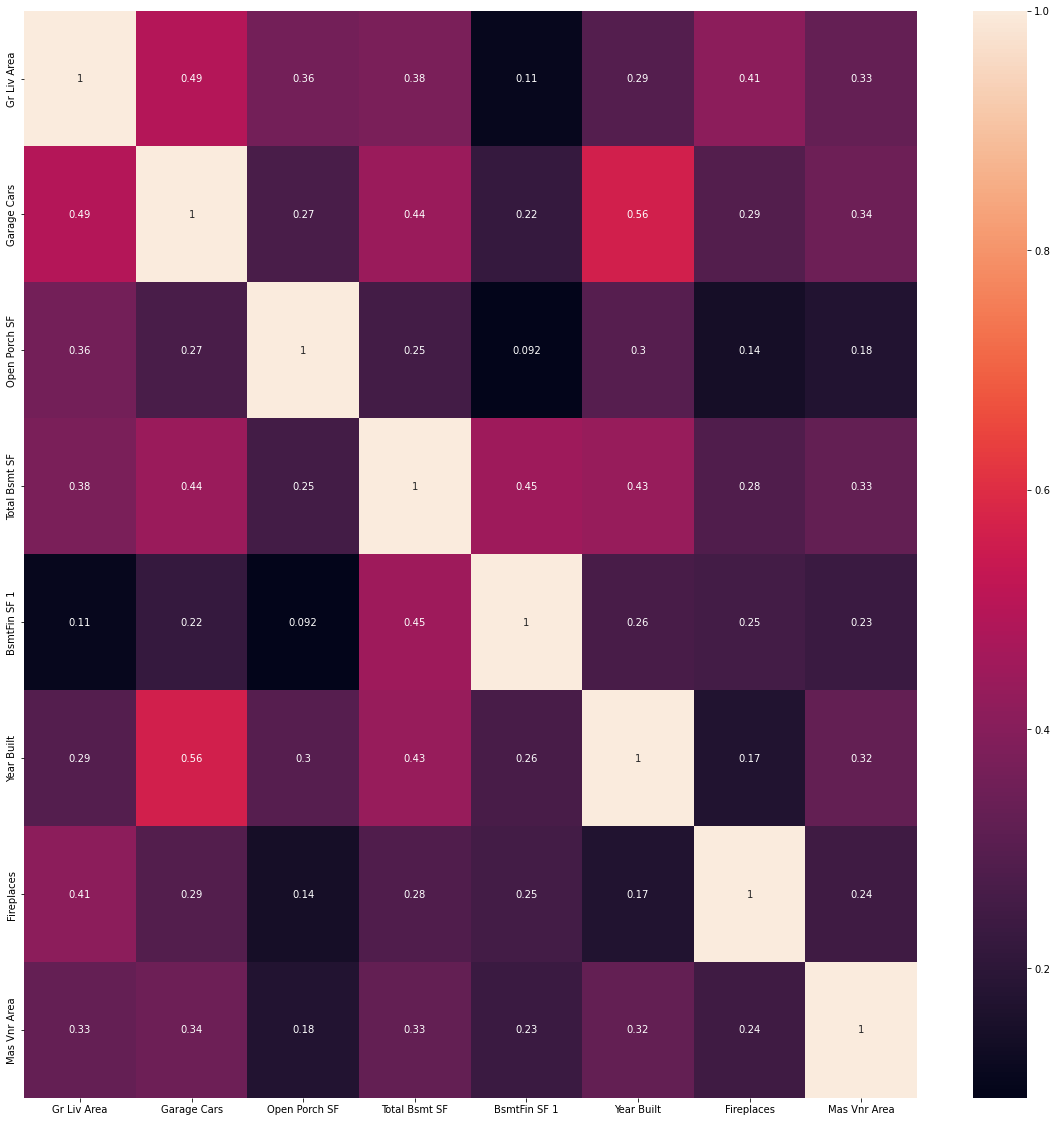

In [71]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_numeric_selected].corr(), annot=True)

### selecting features_ordinal

In [72]:
features_ordinal_selected = select_features_by_corr(df, features_ordinal, target_variable, corr_threhold)

           feature  corr  abs_corr
1     Overall Qual 0.840     0.840
2       Exter Qual 0.723     0.723
3        Bsmt Qual 0.714     0.714
4     Kitchen Qual 0.706     0.706
5    Garage Finish 0.592     0.592
6   BsmtFin Type 1 0.502     0.502
7       Heating QC 0.481     0.481
8     Overall Cond 0.430     0.430
9    Bsmt Exposure 0.410     0.410
10     Garage Qual 0.317     0.317
11     Paved Drive 0.307     0.307
12     Garage Cond 0.304     0.304
13       Lot Shape 0.303     0.303
14      Electrical 0.269     0.269
15       Bsmt Cond 0.258     0.258
16  BsmtFin Type 2 0.187     0.187
17      Exter Cond 0.183     0.183
18      Functional 0.149     0.149
19      Land Slope 0.052     0.052
20       Utilities 0.012     0.012

selected the following features based on corr_threhold 0.4

 ['Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Garage Finish', 'BsmtFin Type 1', 'Heating QC', 'Overall Cond', 'Bsmt Exposure']


**checking multicollinearity of features_ordinal_selected**

<AxesSubplot:>

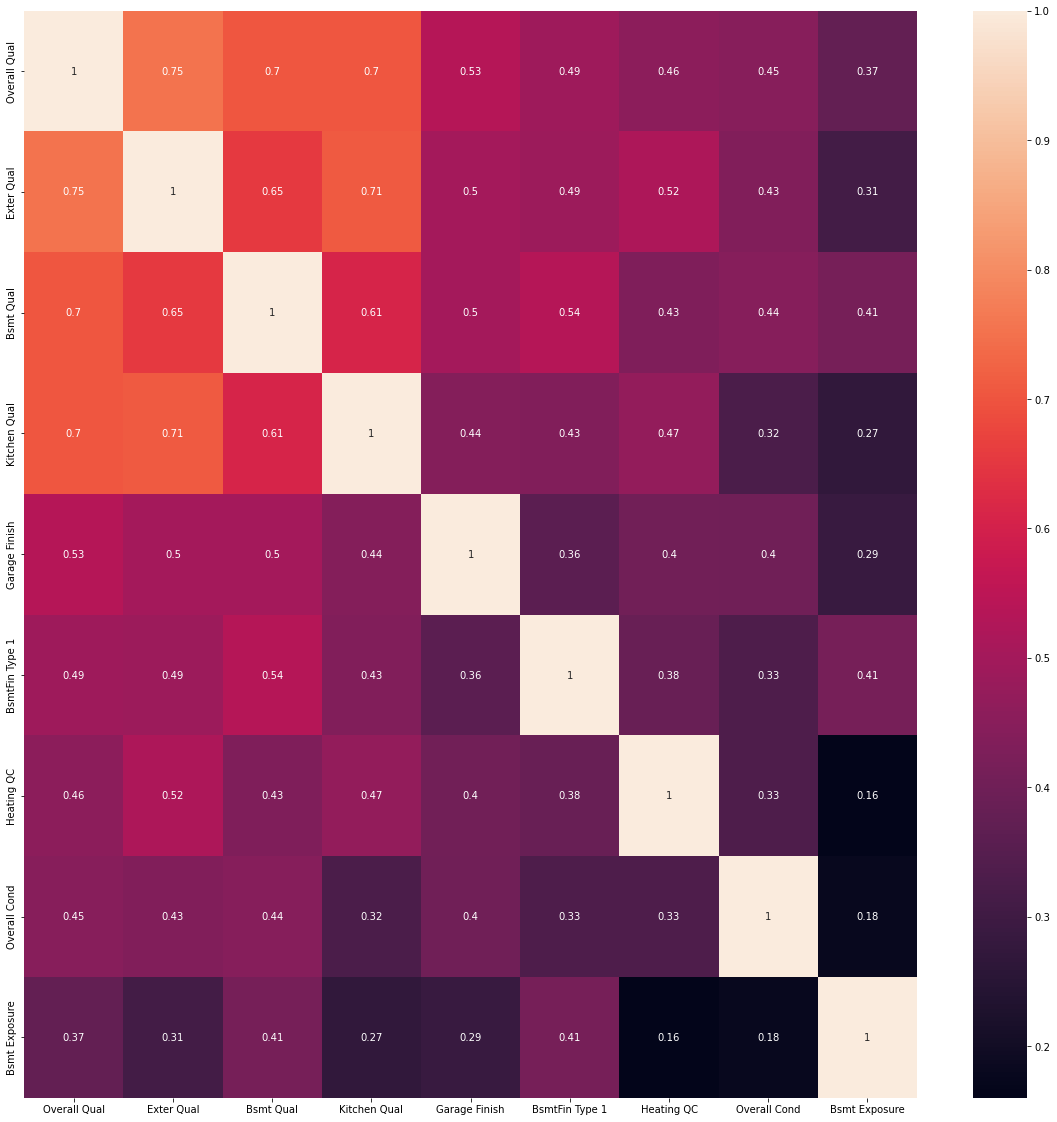

In [73]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_ordinal_selected].corr(), annot=True)

**drop features with corr more than 0.6 with other features**
- we will keep those features with high corr with "SalePrice" when there is a multicollinearity conflict
- 'Overall Qual' is highly correlated with ''Exter Qual', 'Bsmt Qual', 'Kitchen Qual', we will drop the later three


In [74]:
features_ordinal_selected = list(set(features_ordinal_selected ) 
                                -
                                set(['Exter Qual', 'Bsmt Qual', 'Kitchen Qual']))

<AxesSubplot:>

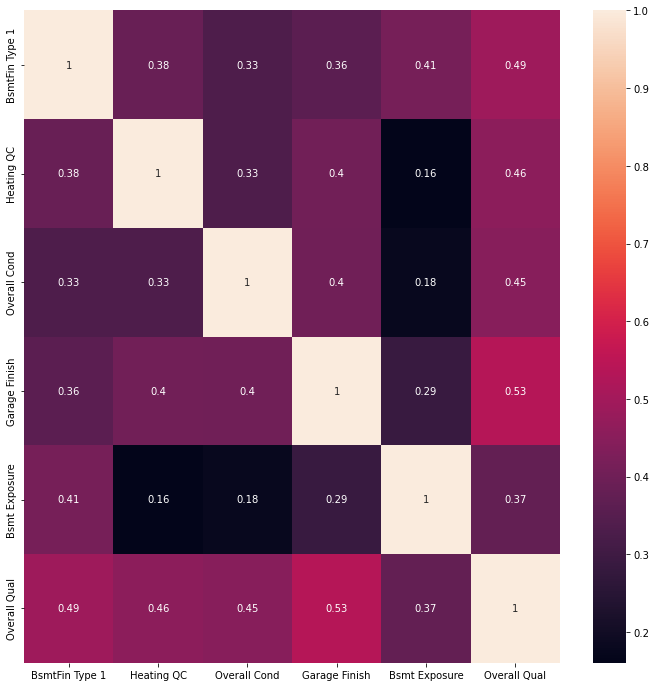

In [75]:
plt.figure(figsize=(12,12))
sns.heatmap(df[features_ordinal_selected].corr(), annot=True)

### selecting features_categorical

In [76]:
features_categorical_selected = select_features_by_corr(df, features_categorical, target_variable, corr_threhold)

         feature  corr  abs_corr
1     Foundation 0.571     0.571
2    Garage Type 0.536     0.536
3    MS SubClass 0.534     0.534
4   Mas Vnr Type 0.452     0.452
5   Exterior 1st 0.449     0.449
6   Exterior 2nd 0.440     0.440
7      Sale Type 0.376     0.376
8      MS Zoning 0.357     0.357
9    Central Air 0.293     0.293
10   House Style 0.279     0.279
11   Condition 1 0.240     0.240
12     Bldg Type 0.211     0.211
13  Land Contour 0.199     0.199
14   Condition 2 0.177     0.177
15    Roof Style 0.176     0.176
16    Lot Config 0.114     0.114
17       Heating 0.112     0.112
18        Street 0.068     0.068
19     Roof Matl 0.046     0.046

selected the following features based on corr_threhold 0.4

 ['Foundation', 'Garage Type', 'MS SubClass', 'Mas Vnr Type', 'Exterior 1st', 'Exterior 2nd']


**checking multicollinearity of features_ordinal_selected**

<AxesSubplot:>

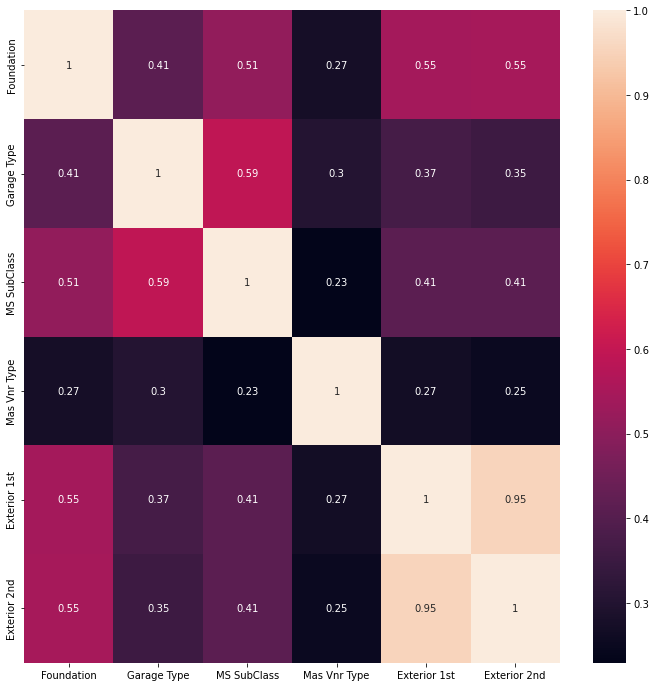

In [77]:
plt.figure(figsize=(12,12))
sns.heatmap(df[features_categorical_selected].corr(), annot=True)

**check and drop features with corr more than 0.6 from the heatmap**
- we will keep those features with high corr with "SalePrice" when there is a multicollinearity conflict
- 'Exterior 1st' is highly correlated with 'Exterior 2nd'', we will drop the later 


In [78]:
features_categorical_selected = list(set(features_categorical_selected ) 
                                -
                                set(['Exterior 2nd']))

<AxesSubplot:>

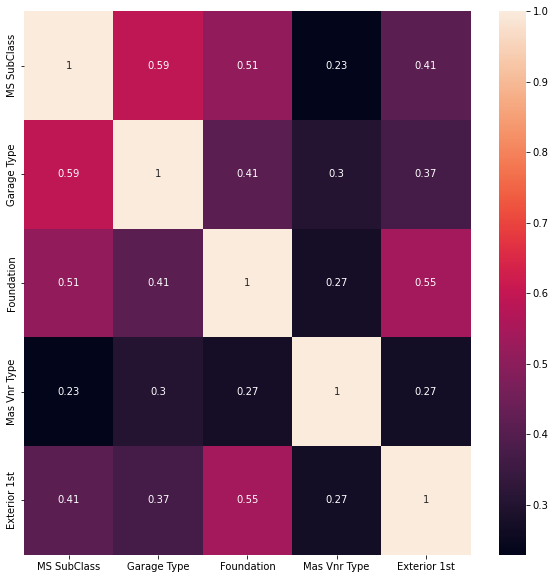

In [79]:
plt.figure(figsize=(10,10))
sns.heatmap(df[features_categorical_selected].corr(), annot=True)

## Preparing features_final

In [80]:
# testing
features_selected = features_numeric_selected + features_ordinal_selected + features_categorical_selected
#features_all = features_numeric + features_ordinal + features_categorical
print(features_selected)
print(len(features_selected))

['Gr Liv Area', 'Garage Cars', 'Open Porch SF', 'Total Bsmt SF', 'BsmtFin SF 1', 'Year Built', 'Fireplaces', 'Mas Vnr Area', 'BsmtFin Type 1', 'Heating QC', 'Overall Cond', 'Garage Finish', 'Bsmt Exposure', 'Overall Qual', 'MS SubClass', 'Garage Type', 'Foundation', 'Mas Vnr Type', 'Exterior 1st']
19


**checking multicollinearity of features_selected**

<AxesSubplot:>

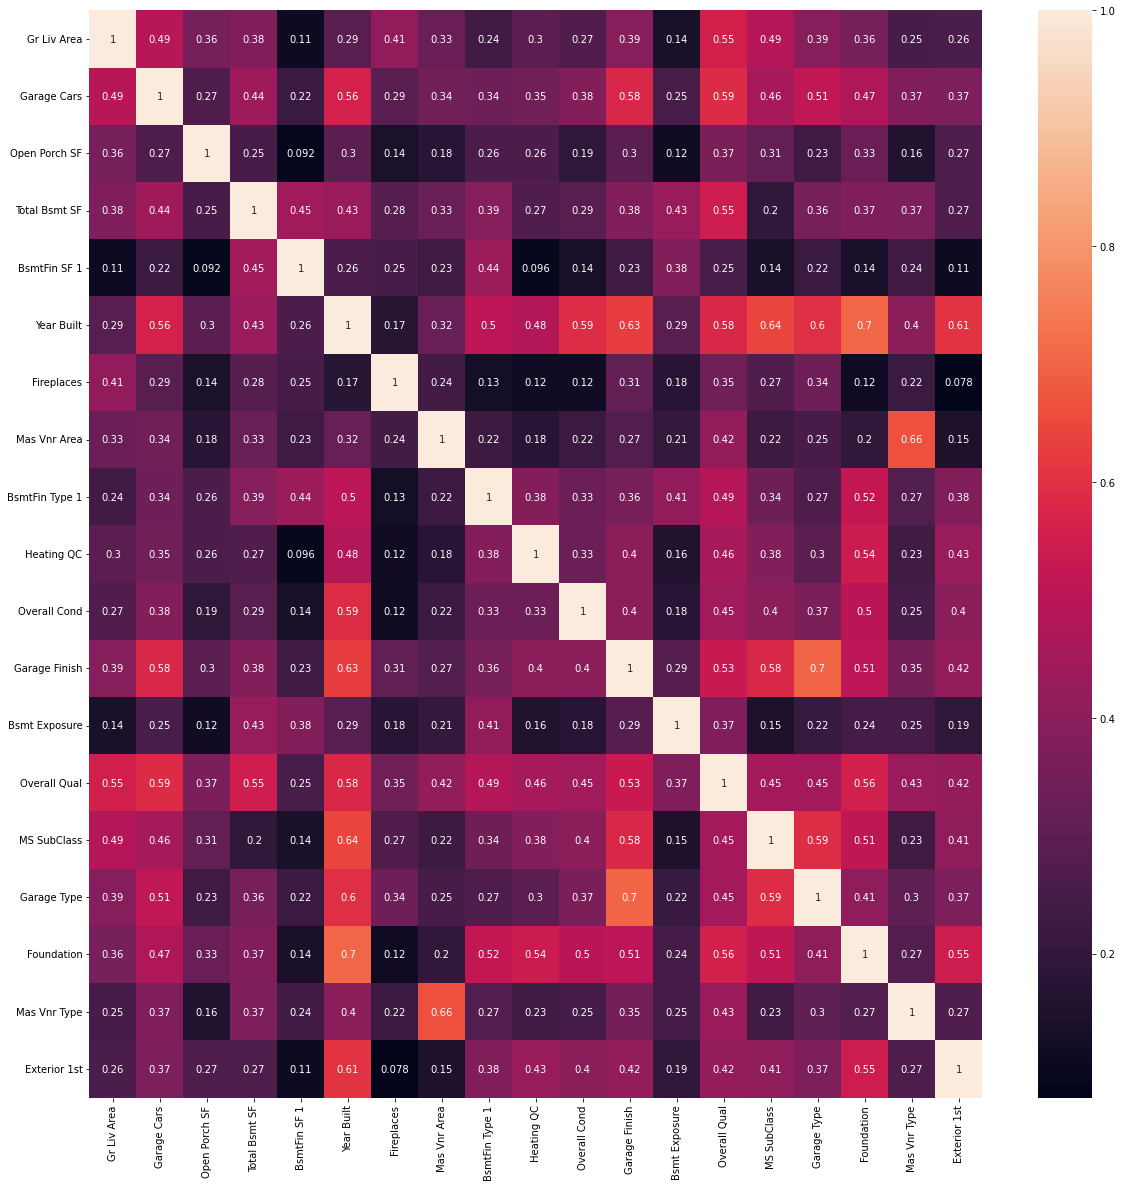

In [81]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_selected].corr(), annot=True)

**Based on same logic, we will drop the features with lower corr with "SalePrice" when they have multicollinearity comflict**

In [82]:
features_final = list(set(features_selected ) 
                      -
                      set(['Year Built','Mas Vnr Type','Garage Type']))
print(features_final)
print(len(features_final))

['Heating QC', 'MS SubClass', 'Garage Finish', 'Open Porch SF', 'Total Bsmt SF', 'Bsmt Exposure', 'Fireplaces', 'Exterior 1st', 'Gr Liv Area', 'BsmtFin Type 1', 'Overall Cond', 'Garage Cars', 'BsmtFin SF 1', 'Foundation', 'Mas Vnr Area', 'Overall Qual']
16


<AxesSubplot:>

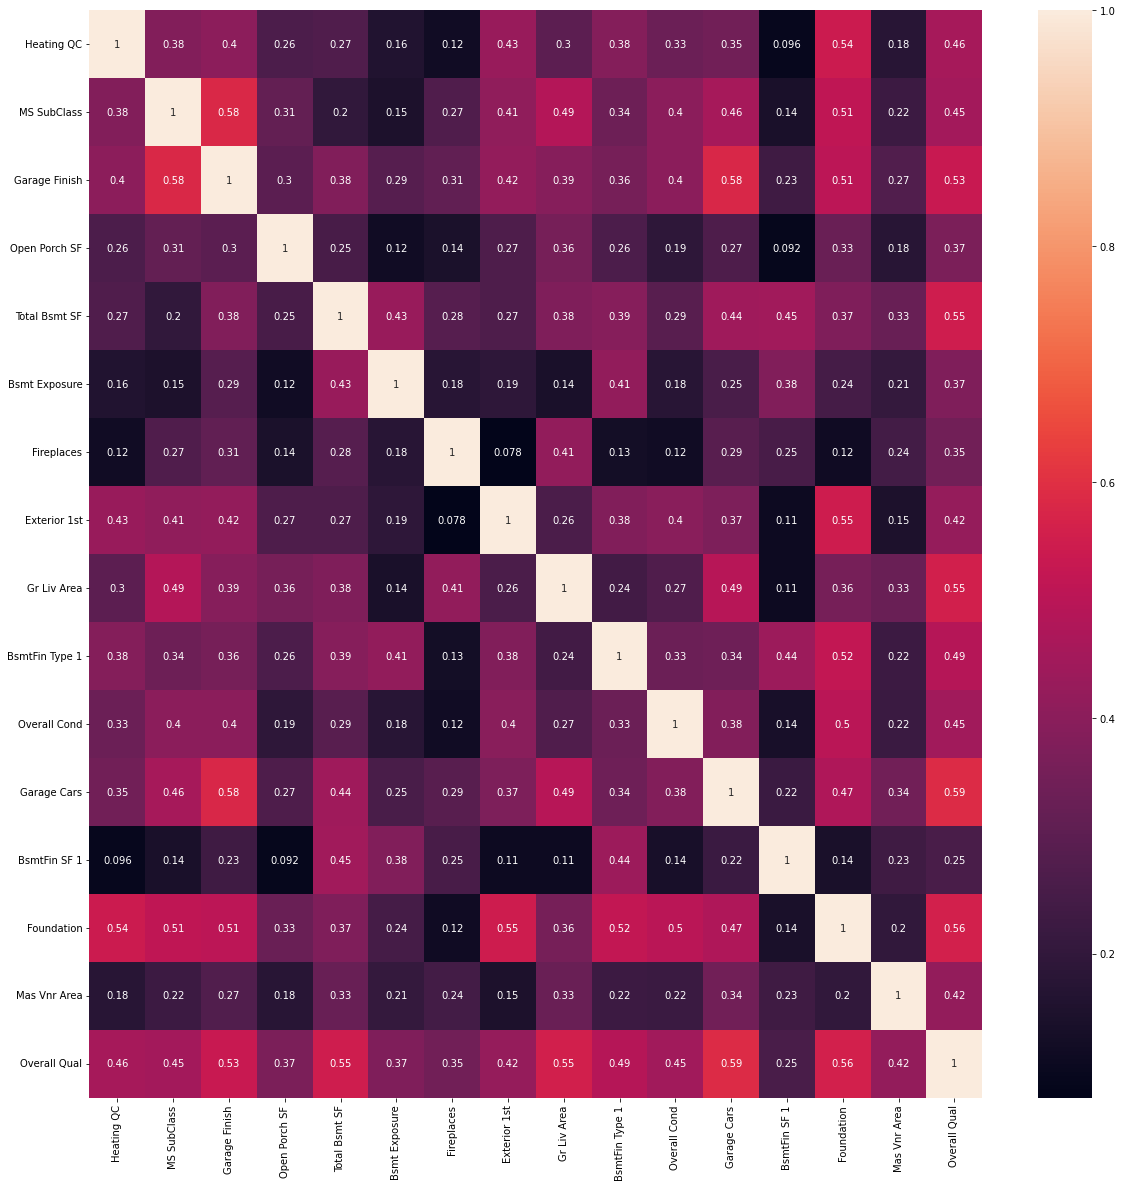

In [83]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_final].corr(), annot=True)

**We have checked and all correlations are less than 0.6**


In [84]:
print(f'features_final has {len(features_final)} features: \n', features_final )

features_final has 16 features: 
 ['Heating QC', 'MS SubClass', 'Garage Finish', 'Open Porch SF', 'Total Bsmt SF', 'Bsmt Exposure', 'Fireplaces', 'Exterior 1st', 'Gr Liv Area', 'BsmtFin Type 1', 'Overall Cond', 'Garage Cars', 'BsmtFin SF 1', 'Foundation', 'Mas Vnr Area', 'Overall Qual']


In [85]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['features_final']=features_final

# Modeling

## 1. Do Train-Test Split

In [86]:
X = df[features_final]
y = df[target_variable]

# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=133)

print(X_train.shape)
print(X_test.shape)

(1406, 16)
(469, 16)


## 2. Metrices
- We use alternative performance measure - MSE
- Smaller MSE indicates a better model, to monitor bias / underfitting
- perc_diff: can not more than 2%, to control variance error /overfitting

## 3. Baseline Model - mean of y_train 

In [87]:
print(f"Mean of 'SalePrice' in y_train is : {y_train.mean():,.2f}")
y_train_pred = [y_train.mean() for i in y_train]
#print(y_train_pred)
y_test_pred = [y_train.mean() for i in y_test]
MSE_baseline, perc_diff_baseline = model_evaluation(y_train,y_train_pred, y_test,y_test_pred)



Mean of 'SalePrice' in y_train is : 173,354.73
mae of train data: 52,418.76
mae of test data: 49,887.69
diff%: 4.83%


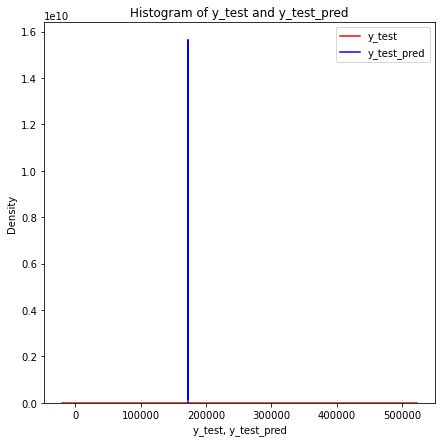

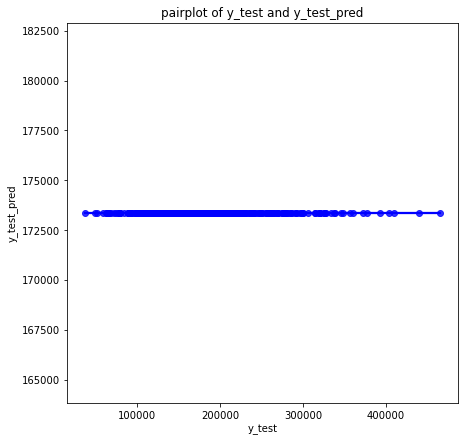

In [88]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred);

## 4.  linear regression

In [89]:
model = LinearRegression()
param = {}

gs, y_train_pred, y_test_pred = run_model(X_train, X_test, y_train, y_test, model, param)
df_coefs = get_coefs(gs)
df_coefs.head(100)

{}
mae of train data: 17,516.56
mae of test data: 17,767.09
diff%: -1.43%


,feature,coef,abs_coef
0,Overall Qual,"30,113.773","30,113.773"
1,Gr Liv Area,"25,962.788","25,962.788"
2,BsmtFin SF 1,"17,429.760","17,429.760"
3,Heating QC,"9,742.835","9,742.835"
4,Total Bsmt SF,"8,672.934","8,672.934"
5,Garage Cars,"8,368.176","8,368.176"
6,Fireplaces,"7,726.425","7,726.425"
7,Foundation,"6,182.984","6,182.984"
8,Exterior 1st,"5,782.254","5,782.254"
9,Mas Vnr Area,"2,821.262","2,821.262"


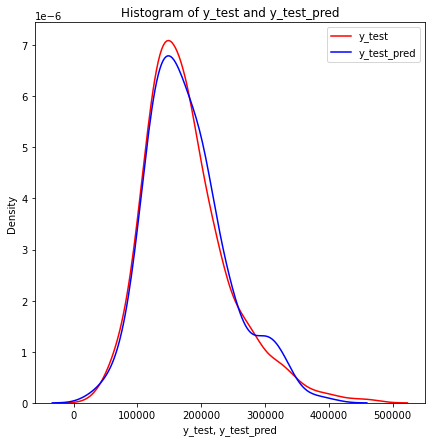

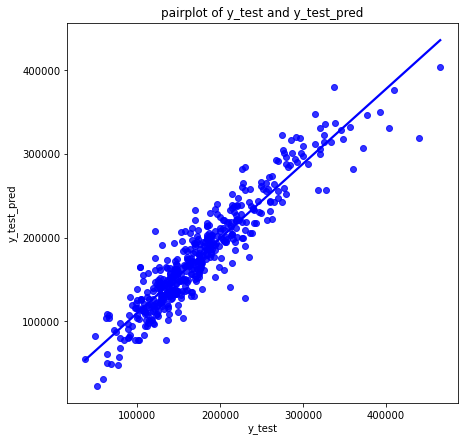

In [90]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred);

## 5. Ridge Regression Model 

In [91]:
model = Ridge()

alphas = np.logspace(-1,3, 100)
param = {'classifier__alpha': alphas}

gs, y_train_pred, y_test_pred= run_model(X_train, X_test, y_train, y_test, model, param)

df_coefs = get_coefs(gs)

df_coefs.head(100)



{'classifier__alpha': 50.9413801481638}
mae of train data: 17,482.24
mae of test data: 17,429.70
diff%: 0.30%


,feature,coef,abs_coef
0,Overall Qual,"28,151.862","28,151.862"
1,Gr Liv Area,"24,144.596","24,144.596"
2,BsmtFin SF 1,"14,816.584","14,816.584"
3,Total Bsmt SF,"9,471.839","9,471.839"
4,Garage Cars,"8,779.481","8,779.481"
5,Heating QC,"8,665.006","8,665.006"
6,Fireplaces,"8,142.117","8,142.117"
7,Foundation,"5,589.669","5,589.669"
8,Exterior 1st,"5,367.248","5,367.248"
9,Mas Vnr Area,"3,362.273","3,362.273"


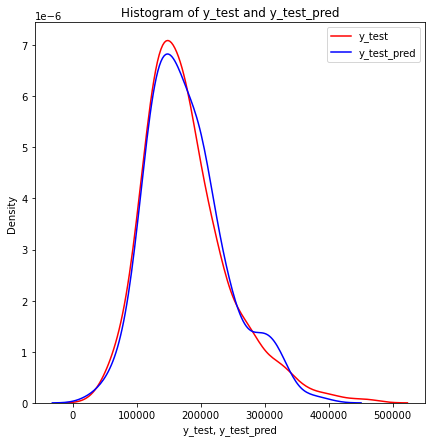

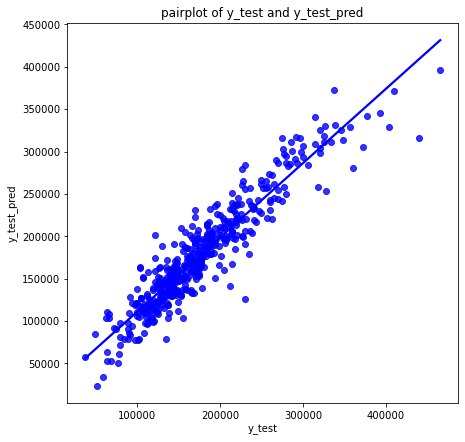

In [92]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred);

## 6. Lasso Regression Model

In [93]:
X = df[features_final]
y = df[target_variable]

# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=133)

model = Lasso()
alphas = np.logspace(-1,3, 100)
param = {'classifier__alpha': alphas}

gs, y_train_pred, y_test_pred = run_model(X_train, X_test, y_train, y_test, model, param)

df_coefs = get_coefs(gs)
df_coefs.head(100)

{'classifier__alpha': 830.2175681319752}
mae of train data: 17,390.94
mae of test data: 17,428.08
diff%: -0.21%


,feature,coef,abs_coef
0,Overall Qual,"31,484.658","31,484.658"
1,Gr Liv Area,"25,591.430","25,591.430"
2,BsmtFin SF 1,"14,913.515","14,913.515"
3,Total Bsmt SF,"8,849.742","8,849.742"
4,Garage Cars,"8,233.271","8,233.271"
5,Heating QC,"7,326.668","7,326.668"
6,Fireplaces,"6,150.135","6,150.135"
7,Foundation,"4,062.086","4,062.086"
8,Exterior 1st,"3,542.281","3,542.281"
9,Garage Finish,"2,395.198","2,395.198"


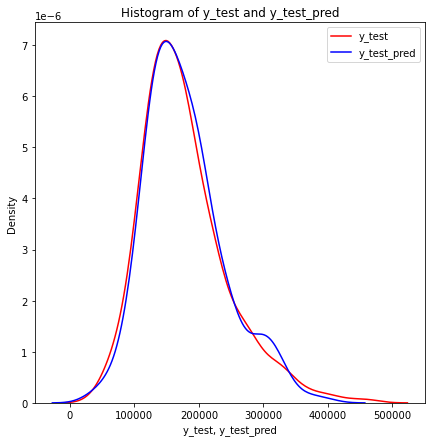

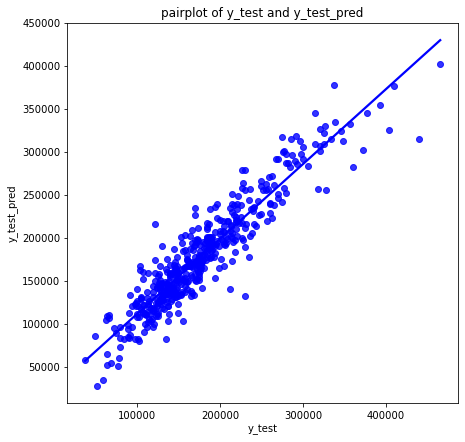

In [94]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred)

# Production Model

We will use the model derived by Lasso because of this model has reduced 2 more features while it still has similiar RMSE

**Observations**:
- all 3 modals have similiar results, which indicating there is no overfitting issues, but all models may have bias

In [95]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['production model']=gs
pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb'))
print(pickle_dict)

{'features_numeric': ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold'], 'features_categorical': ['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning'], 'features_ordinal': ['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 

# LINE Assumptions

In [84]:
# Create residuals (aka errors): (y - y_hat)
resids_test = y_test - y_test_pred

#### Linearity

In [86]:
plot_features(df,features_coefs[:-2], target_variable, columns_in_a_row = 5, feature_type='numeric',if_show_histo=False)


NameError: name 'features_coefs' is not defined

**Note:**
- most features have some trends with "SalePrice" while some features seem not to have trends


### Independence

<AxesSubplot:>

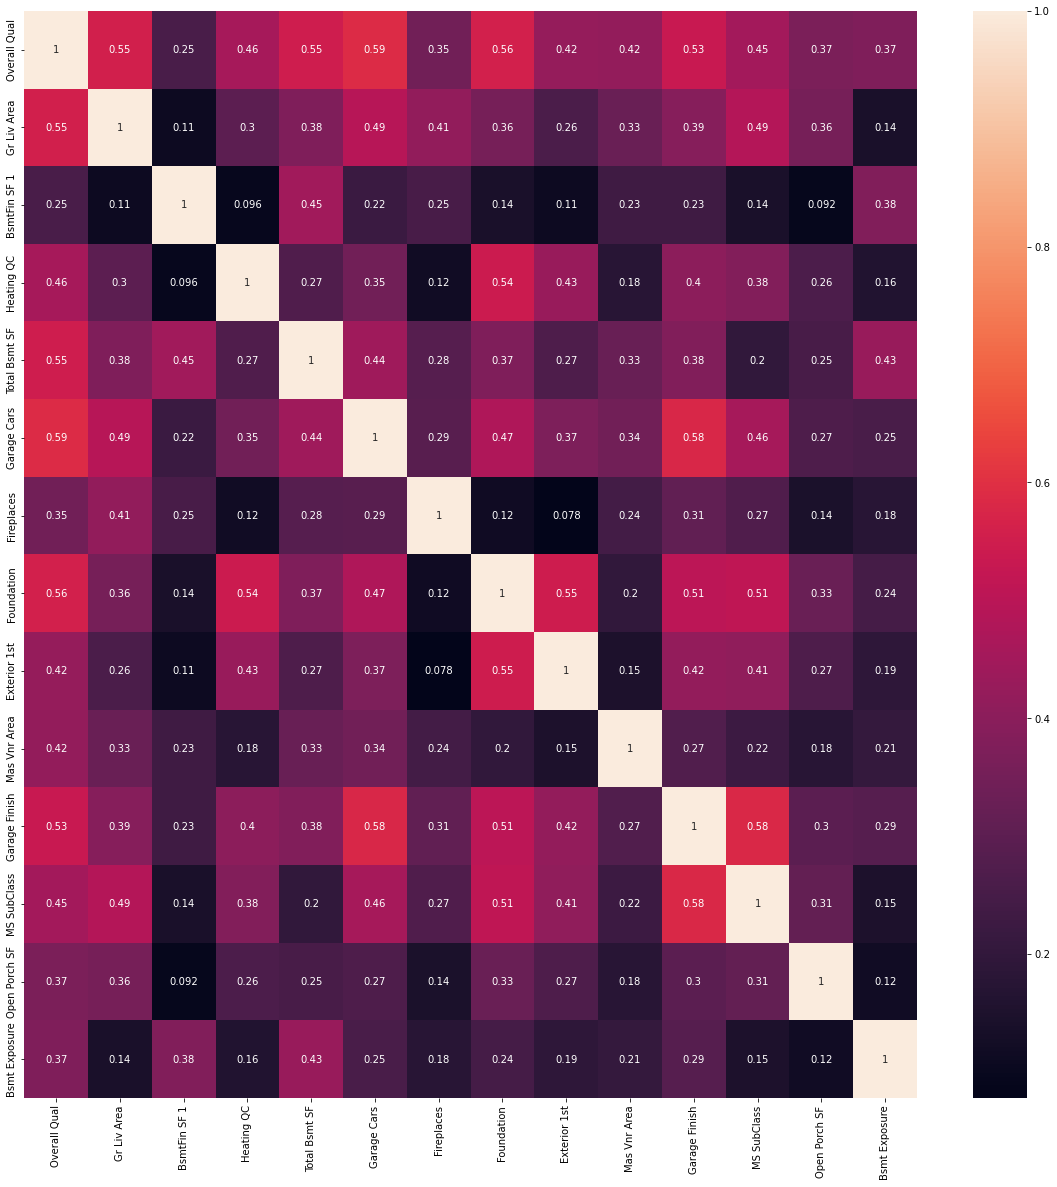

In [1053]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_coefs[:-2]].corr(), annot=True)

In [1054]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features_coefs[:-2]

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df[features_coefs[:-2]].values, i)
                          for i in range(len(df[features_coefs[:-2]].columns))]
vif_data.sort_values(by=['VIF'], inplace=True, ascending=True)   

vif_data.head(100)

,feature,VIF
9,Mas Vnr Area,1.769
12,Open Porch SF,1.930
6,Fireplaces,2.439
2,BsmtFin SF 1,2.742
5,Garage Cars,12.317
4,Total Bsmt SF,14.832
1,Gr Liv Area,22.427
0,Overall Qual,25.128
13,Bsmt Exposure,37.022
8,Exterior 1st,42.065


In [1055]:
df_coefs = pd.merge( df_coefs,vif_data, on='feature')

In [1056]:
df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False) 
df_coefs.head(100)

,feature,coef,abs_coef,VIF
0,Overall Qual,"31,483.529","31,483.529",25.128
1,Gr Liv Area,"25,592.408","25,592.408",22.427
2,BsmtFin SF 1,"14,915.986","14,915.986",2.742
3,Total Bsmt SF,"8,844.509","8,844.509",14.832
4,Garage Cars,"8,238.878","8,238.878",12.317
5,Heating QC,"7,330.180","7,330.180",49.049
6,Fireplaces,"6,150.089","6,150.089",2.439
7,Foundation,"4,070.950","4,070.950",52.912
8,Exterior 1st,"3,537.855","3,537.855",42.065
9,Garage Finish,"2,387.052","2,387.052",49.474


### Normality of errors

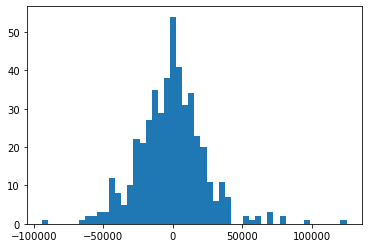

In [1057]:
plt.hist(resids_test, bins=50);

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


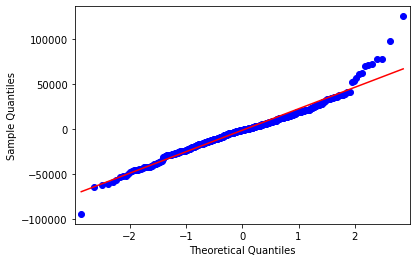

In [1058]:
#qq plot
# q-q plot
qqplot(resids_test,line='s')
plt.show();



### Equal variance of errors

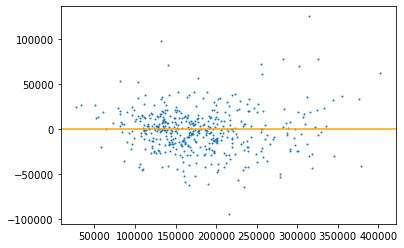

In [1059]:
plt.scatter(y_test_pred, resids_test, s=1)
plt.axhline(0, color="orange");

# Try to create models for each neighborhood

In [1060]:
neighborhoods = df['Neighborhood'].unique()

In [1061]:
print(features_coefs)

['Overall Qual' 'Gr Liv Area' 'BsmtFin SF 1' 'Heating QC' 'Total Bsmt SF'
 'Garage Cars' 'Fireplaces' 'Foundation' 'Exterior 1st' 'Mas Vnr Area'
 'Garage Finish' 'MS SubClass' 'Open Porch SF' 'Bsmt Exposure'
 'Overall Cond' 'BsmtFin Type 1']


In [1062]:
features_final2= features_coefs[:-2]
print(features_final2)

['Overall Qual' 'Gr Liv Area' 'BsmtFin SF 1' 'Heating QC' 'Total Bsmt SF'
 'Garage Cars' 'Fireplaces' 'Foundation' 'Exterior 1st' 'Mas Vnr Area'
 'Garage Finish' 'MS SubClass' 'Open Porch SF' 'Bsmt Exposure']


In [1063]:
X_dict = {}
for neighborhood in neighborhoods:
    #print(neighborhood)
    X=df.loc[df['Neighborhood'].str.contains(neighborhood),:]
    print(neighborhood, ': shape:', X.shape)
    X_dict[neighborhood] = X
    

Sawyer : shape: (185, 76)
SawyerW : shape: (78, 76)
NAmes : shape: (288, 76)
Timber : shape: (39, 76)
Edwards : shape: (136, 76)
BrDale : shape: (17, 76)
CollgCr : shape: (176, 76)
Somerst : shape: (125, 76)
Mitchel : shape: (72, 76)
OldTown : shape: (151, 76)
StoneBr : shape: (30, 76)
NridgHt : shape: (98, 76)
Gilbert : shape: (110, 76)
Crawfor : shape: (63, 76)
IDOTRR : shape: (64, 76)
NWAmes : shape: (81, 76)
Veenker : shape: (14, 76)
MeadowV : shape: (23, 76)
SWISU : shape: (29, 76)
NoRidge : shape: (33, 76)
ClearCr : shape: (18, 76)
Blmngtn : shape: (22, 76)
BrkSide : shape: (72, 76)
NPkVill : shape: (17, 76)
Blueste : shape: (6, 76)
GrnHill : shape: (2, 76)
Greens : shape: (3, 76)
Landmrk : shape: (1, 76)


In [1064]:
X=X_dict["NAmes"][features_final2]
X.head()

,Overall Qual,Gr Liv Area,BsmtFin SF 1,Heating QC,Total Bsmt SF,Garage Cars,Fireplaces,Foundation,Exterior 1st,Mas Vnr Area,Garage Finish,MS SubClass,Open Porch SF,Bsmt Exposure
2,"132,500.000",1057,731.000,"133,600.000","1,057.000",1.000,0,"139,500.000","199,250.000",0.000,"134,500.000","157,000.000",52,"149,425.000"
5,"158,000.000",1888,247.000,"191,000.000","1,517.000",2.000,1,"139,500.000","159,750.000",0.000,"206,300.000","157,000.000",0,"149,425.000"
7,"132,500.000",1188,"1,000.000","111,000.000","1,188.000",2.000,0,"139,500.000","152,500.000",180.000,"188,250.000","157,000.000",0,"149,425.000"
9,"132,500.000",2080,650.000,"133,600.000","1,040.000",2.000,2,"203,000.000","152,500.000",192.000,"134,500.000","212,554.500",0,"183,500.000"
25,"158,000.000",1453,"1,312.000","191,000.000","1,453.000",2.000,1,"139,500.000","136,500.000",3.000,"188,250.000","157,000.000",49,"149,425.000"


In [1065]:
y = X_dict["NAmes"][target_variable]
y.head()

2     109000
5     190000
7     142000
9     135000
25    187500
Name: SalePrice, dtype: int64

In [1067]:

# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=133)

model = Lasso()
alphas = np.logspace(-1,3, 100)
param = {'classifier__alpha': alphas}

gs, y_train_pred, y_test_pred = run_model(X_train, X_test, y_train, y_test, model, param)

df_coefs = get_coefs(gs)
df_coefs.head(100)

{'classifier__alpha': 572.236765935022}
mae of train data: 10,087.47
mae of test data: 11,739.54
diff%: -16.38%


,feature,coef,abs_coef
0,Heating QC,"9,166.051","9,166.051"
1,Bsmt Exposure,"7,410.236","7,410.236"
2,Open Porch SF,"5,977.291","5,977.291"
3,Garage Finish,"5,605.465","5,605.465"
4,MS SubClass,"4,100.068","4,100.068"
5,Foundation,"3,971.690","3,971.690"
6,Gr Liv Area,"2,070.617","2,070.617"
7,Total Bsmt SF,"1,874.150","1,874.150"
8,Overall Cond,"1,607.795","1,607.795"
9,BsmtFin SF 1,"1,462.145","1,462.145"


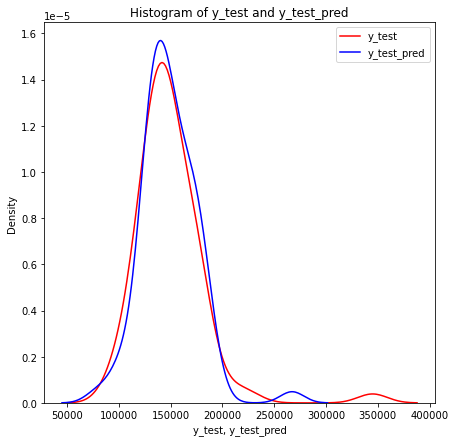

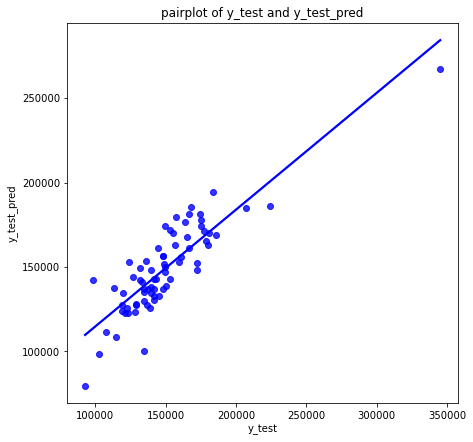

In [1068]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred)

# Conclusions and Recommendations